<h1><font color='blue'>Introduction</font></h1>

In the CMS experiment at the LHC, data certification (DC) and data quality monitoring (DQM) are a neccesary precursor to any physics analysis. However, currently shifters doing DC are only able to evaluate the run mostly at the run level. This is problematic, as if there are any problems at the lumisection level, they can be easily overlooked. In this notebook, we will develop a convolutional autoencoder ensemble which is able to detect problems at lumisection level, while still being relatively undemanding computationally. With this ensemble, we will also do a quick evaluation of the accuracy of shifters.

<h1><font color='blue'>Setup</font></h1>

We start by importing all the neccessary python libraries. Note that we will construct the autoencoder using Tensorflow and so we must import all the neccessary functions and classes.

In [96]:
# Importing basic tools
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import glob
import sys, os
import importlib
from ast import literal_eval

# Importing AE related tools
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Activation, LeakyReLU, Flatten, Reshape, Conv1D
from tensorflow.keras.saving import load_model
from tensorflow.keras.losses import kullback_leibler_divergence
from tensorflow.math import reduce_mean
from sklearn.model_selection import train_test_split

# Importing user defined utilities for data manipulation, plotting, etc.
sys.path.append(os.path.abspath('utilities'))
import data_utils as datau
import json_utils
import refruns_utils
import plot_utils as pltu

In [236]:
# In case of live editing of the utilities

# importlib.reload(data_utils)
# importlib.reload(json_utils)
# importlib.reload(refruns_utils)
# importlib.reload(pltu)

<module 'plot_utils' from '/eos/home-i02/r/rcruzcan/SWAN_projects/ANN-FauxShifter/utilities/plot_utils.py'>

In [134]:
np.array([1,2,3,4,5,])

array([], dtype=int64)

<h1><font color='blue'>Importing the data</font></h1>

<!--   - PixelPhase1/Tracks/PXBarrel/charge_PXLayer_1
  - PixelPhase1/Tracks/PXBarrel/charge_PXLayer_2
  - PixelPhase1/Tracks/PXBarrel/charge_PXLayer_3
  - PixelPhase1/Tracks/PXBarrel/charge_PXLayer_4
  - PixelPhase1/Tracks/PXBarrel/clusterposition_zphi_ontrack_PXLayer_1
  - PixelPhase1/Tracks/PXBarrel/clusterposition_zphi_ontrack_PXLayer_2
  - PixelPhase1/Tracks/PXBarrel/clusterposition_zphi_ontrack_PXLayer_3
  - PixelPhase1/Tracks/PXBarrel/clusterposition_zphi_ontrack_PXLayer_4
  - PixelPhase1/Tracks/PXBarrel/size_PXLayer_1
  - PixelPhase1/Tracks/PXBarrel/size_PXLayer_2
  - PixelPhase1/Tracks/PXBarrel/size_PXLayer_3
  - PixelPhase1/Tracks/PXBarrel/size_PXLayer_4
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_+1
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_+2
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_+3
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_-1
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_-2
  - PixelPhase1/Tracks/PXForward/charge_PXDisk_-3
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_+1
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_+2
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_+3
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_-1
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_-2
  - PixelPhase1/Tracks/PXForward/clusterposition_xy_ontrack_PXDisk_-3
  - PixelPhase1/Tracks/PXForward/size_PXDisk_+1
  - PixelPhase1/Tracks/PXForward/size_PXDisk_+2
  - PixelPhase1/Tracks/PXForward/size_PXDisk_+3
  - PixelPhase1/Tracks/PXForward/size_PXDisk_-1
  - PixelPhase1/Tracks/PXForward/size_PXDisk_-2
  - PixelPhase1/Tracks/PXForward/size_PXDisk_-3
  - PixelPhase1/Tracks/charge_PXBarrel
  - PixelPhase1/Tracks/charge_PXForward
  - PixelPhase1/Tracks/clusterposition_zphi_ontrack
  - PixelPhase1/Tracks/num_clusters_ontrack_PXBarrel
  - PixelPhase1/Tracks/num_clusters_ontrack_PXForward -->
  
<!-- <h2> Importing the data </h2> -->
  
We can have a look at all of the available monitoring elements by loading one of the CSV data files into a pandas dataframe and taking a look at the `'hname'` column which contains the histogram/monitoring element name.

In [3]:
DF2017ZeroBias_df = pd.read_csv('data/DF2017B_1D_Complete/ZeroBias_2017B_DataFrame_1D_1.csv')

print('Available monitoring elements:')
DF2017ZeroBias_df['hname'].unique().tolist()

Available monitoring elements:


['goodvtxNbr',
 'adc_PXLayer_1',
 'adc_PXLayer_2',
 'adc_PXLayer_3',
 'adc_PXLayer_4',
 'adc_PXDisk_+1',
 'adc_PXDisk_+2',
 'adc_PXDisk_+3',
 'adc_PXDisk_-1',
 'adc_PXDisk_-2',
 'adc_PXDisk_-3',
 'num_clusters_ontrack_PXBarrel',
 'num_clusters_ontrack_PXForward',
 'chargeInner_PXLayer_1',
 'chargeInner_PXLayer_2',
 'chargeInner_PXLayer_3',
 'chargeInner_PXLayer_4',
 'chargeOuter_PXLayer_1',
 'chargeOuter_PXLayer_2',
 'chargeOuter_PXLayer_3',
 'chargeOuter_PXLayer_4',
 'size_PXLayer_1',
 'size_PXLayer_2',
 'size_PXLayer_3',
 'size_PXLayer_4',
 'charge_PXDisk_+1',
 'charge_PXDisk_+2',
 'charge_PXDisk_+3',
 'charge_PXDisk_-1',
 'charge_PXDisk_-2',
 'charge_PXDisk_-3',
 'size_PXDisk_+1',
 'size_PXDisk_+2',
 'size_PXDisk_+3',
 'size_PXDisk_-1',
 'size_PXDisk_-2',
 'size_PXDisk_-3',
 'MainDiagonal Position',
 'NumberOfClustersInPixel',
 'NumberOfClustersInStrip',
 'NormalizedHitResiduals_TEC__wheel__1',
 'Summary_ClusterStoNCorr__OnTrack__TEC__MINUS__wheel__1',
 'NormalizedHitResiduals_TEC__

We can see here that there is large number of possible monitoring elements we could use. However, for our purposes and for the sake of simplicity, we will only focus on a subset of the available monitoring element, namely a subset of the ones which correspond to the Pixel Phase 1 System. We define a list containing the name of all the monitoring element we will be using.

In [4]:
monitoring_elems = [
    'chargeInner_PXLayer_1',
    'chargeInner_PXLayer_2',
    'chargeInner_PXLayer_3',
    'chargeInner_PXLayer_4',
    'chargeOuter_PXLayer_1',
    'chargeOuter_PXLayer_2',
    'chargeOuter_PXLayer_3',
    'chargeOuter_PXLayer_4',
    'charge_PXDisk_+1',
    'charge_PXDisk_+2',
    'charge_PXDisk_+3',
    'charge_PXDisk_-1',
    'charge_PXDisk_-2',
    'charge_PXDisk_-3',
    'num_clusters_ontrack_PXBarrel',
    'num_clusters_ontrack_PXForward',
]

If we haven't done so already, we would need to process the original `.csv` files. They are assumed to be in a directory named `data` and, when we use `data_utils.dump1dtocsv`, we extract the relevant monitoring element histogram for all the runs in all the available files and then we dump them into their own files. This would need to be done only once.

In [11]:
all_files = os.listdir('proc_data')
all_files = [os.path.join('./proc_data', file) for file in all_files]

for i, me in enumerate(monitoring_elems):
    fname = './proc_data/ZeroBias_2017UL_DataFrame_' + me + '.csv'
    if fname in all_files:
        continue
    data_utils.dump1dtocsv(monitoring_elems[i], monitoring_elems, verbose=False)

With the monitoring element histograms now in the `proc_data` directory, we proceed to load all of the histograms into a single dataframe name `me_df`.

In [7]:
all_files = glob.glob('./proc_data/*')
me_dict = {}

for i, file in enumerate(all_files):
    me_name = file[38:][0:-4]
    print('Reading {}'.format(file))
    if i == 0:
        me_df = pd.read_csv(file)
        me_df.rename(columns={'histo': me_name+'_hist'}, inplace=True)
        me_df[me_name+'_hist'] = me_df[me_name+'_hist'].apply(literal_eval).apply(np.array)
        continue
    me_df = me_df.join(pd.read_csv(file)['histo'].rename(me_name+'_hist'))
    me_df[me_name+'_hist'] = me_df[me_name+'_hist'].apply(literal_eval).apply(np.array)

Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeInner_PXLayer_1.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeInner_PXLayer_2.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeInner_PXLayer_3.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeInner_PXLayer_4.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeOuter_PXLayer_1.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeOuter_PXLayer_2.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeOuter_PXLayer_3.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_chargeOuter_PXLayer_4.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_+1.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_+2.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_+3.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_-1.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_-2.csv
Reading ./proc_data/ZeroBias_2017UL_DataFrame_charge_PXDisk_-3.csv
Reading ./proc_data/Ze

Taking a closer look at the details of the data we just loaded...

In [9]:
me_df.head()

Unnamed: 0  fromrun  fromlumi                  hname  entries     Xmax  \
0           0   299178       105  chargeInner_PXLayer_1   213731  80000.0   
1           1   299178       106  chargeInner_PXLayer_1   202644  80000.0   
2           2   297282        13  chargeInner_PXLayer_1   190027  80000.0   
3           3   297282        14  chargeInner_PXLayer_1   190544  80000.0   
4           4   297282        15  chargeInner_PXLayer_1   197012  80000.0   

   Xmin  Xbins  metype                         chargeInner_PXLayer_1_hist  \
0   0.0    100       3  [0, 125, 780, 1459, 2153, 2785, 3088, 3388, 35...   
1   0.0    100       3  [0, 109, 728, 1419, 2019, 2612, 2925, 3215, 34...   
2   0.0    100       3  [0, 112, 493, 998, 1616, 2256, 2899, 3695, 416...   
3   0.0    100       3  [0, 110, 481, 970, 1610, 2338, 2861, 3701, 427...   
4   0.0    100       3  [0, 92, 510, 1027, 1660, 2390, 3021, 3854, 430...   

   ...                         chargeOuter_PXLayer_3_hist  \
0  ...  [0, 0, 3, 34, 68, 123, 143, 157, 153, 127, 143...   
1  ...  [0, 0, 1, 40, 75, 122, 136, 138, 164, 151, 132...   
2  ...  [0, 0, 1, 78, 183, 240, 255, 247, 261, 272, 31...   
3  ...  [0, 0, 2, 91, 198, 254, 261, 233, 258, 311, 32...   
4  ...  [0, 0, 3, 87, 227, 263, 267, 267, 280, 338, 30...   

                          chargeOuter_PXLayer_4_hist  \
0  [0, 0, 0, 7, 44, 65, 97, 100, 103, 116, 112, 1...   
1  [0, 0, 0, 5, 45, 82, 103, 87, 91, 75, 86, 86, ...   
2  [0, 0, 0, 43, 145, 179, 220, 206, 205, 229, 24...   
3  [0, 0, 0, 43, 166, 189, 193, 235, 202, 227, 25...   
4  [0, 0, 0, 38, 138, 239, 235, 234, 212, 218, 27...   

                               charge_PXDisk_+1_hist  \
0  [0, 0, 0, 0, 2, 88, 97, 114, 121, 110, 103, 13...   
1  [0, 0, 0, 0, 0, 86, 101, 79, 103, 120, 103, 13...   
2  [0, 0, 0, 1, 3, 249, 291, 304, 340, 388, 447, ...   
3  [0, 0, 0, 1, 0, 234, 321, 298, 332, 383, 461, ...   
4  [0, 0, 0, 0, 2, 240, 301, 310, 363, 397, 468, ...   

                               charge_PXDisk_+2_hist  \
0  [0, 0, 0, 0, 0, 37, 67, 66, 69, 73, 80, 81, 10...   
1  [0, 0, 0, 0, 1, 42, 71, 76, 70, 77, 67, 104, 1...   
2  [0, 0, 0, 0, 0, 151, 216, 205, 197, 237, 278, ...   
3  [0, 0, 0, 0, 0, 159, 216, 204, 212, 240, 322, ...   
4  [0, 0, 1, 0, 0, 169, 221, 181, 232, 255, 277, ...   

                               charge_PXDisk_+3_hist  \
0  [0, 0, 0, 0, 0, 34, 69, 62, 64, 79, 72, 74, 91...   
1  [0, 0, 0, 0, 0, 41, 54, 65, 75, 74, 65, 74, 95...   
2  [0, 0, 0, 0, 0, 193, 262, 226, 177, 204, 224, ...   
3  [0, 0, 0, 0, 0, 202, 278, 197, 195, 208, 266, ...   
4  [0, 0, 0, 0, 0, 168, 269, 217, 216, 209, 259, ...   

                               charge_PXDisk_-1_hist  \
0  [0, 0, 0, 0, 0, 71, 111, 109, 93, 96, 112, 129...   
1  [0, 0, 0, 1, 0, 56, 99, 93, 115, 104, 116, 134...   
2  [0, 0, 0, 0, 1, 208, 250, 252, 273, 281, 329, ...   
3  [0, 0, 0, 0, 0, 204, 303, 261, 257, 292, 350, ...   
4  [0, 0, 0, 0, 2, 201, 318, 251, 295, 305, 374, ...   

                               charge_PXDisk_-2_hist  \
0  [0, 0, 0, 0, 0, 57, 89, 90, 72, 109, 90, 110, ...   
1  [0, 0, 0, 0, 1, 45, 82, 77, 86, 86, 83, 140, 1...   
2  [0, 0, 0, 0, 0, 180, 261, 265, 260, 308, 337, ...   
3  [0, 0, 0, 0, 0, 190, 256, 247, 282, 313, 341, ...   
4  [0, 0, 0, 0, 0, 199, 262, 269, 247, 283, 363, ...   

                               charge_PXDisk_-3_hist  \
0  [0, 0, 0, 0, 0, 47, 56, 85, 64, 85, 90, 90, 10...   
1  [0, 0, 0, 0, 0, 49, 81, 69, 68, 78, 72, 106, 8...   
2  [0, 0, 0, 0, 0, 147, 237, 220, 253, 282, 283, ...   
3  [0, 0, 0, 0, 0, 173, 271, 225, 238, 287, 299, ...   
4  [0, 0, 0, 0, 0, 155, 243, 249, 236, 277, 323, ...   

                  num_clusters_ontrack_PXBarrel_hist  \
0  [0, 566, 0, 2, 7, 34, 55, 87, 129, 157, 198, 2...   
1  [0, 538, 0, 3, 10, 24, 48, 70, 124, 164, 205, ...   
2  [0, 424, 0, 1, 2, 11, 39, 72, 140, 194, 231, 2...   
3  [0, 427, 0, 2, 1, 11, 32, 60, 116, 163, 230, 2...   
4  [0, 419, 0, 2, 6, 19, 37, 84, 131, 182, 223, 2...   

              

In [151]:
me_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28335 entries, 0 to 28334
Data columns (total 21 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   fromrun                              28335 non-null  int64 
 1   fromlumi                             28335 non-null  int64 
 2   entries                              28335 non-null  int64 
 3   chargeInner_PXLayer_1_hist           28335 non-null  object
 4   chargeInner_PXLayer_2_hist           28335 non-null  object
 5   chargeInner_PXLayer_3_hist           28335 non-null  object
 6   chargeInner_PXLayer_4_hist           28335 non-null  object
 7   chargeOuter_PXLayer_1_hist           28335 non-null  object
 8   chargeOuter_PXLayer_2_hist           28335 non-null  object
 9   chargeOuter_PXLayer_3_hist           28335 non-null  object
 10  chargeOuter_PXLayer_4_hist           28335 non-null  object
 11  charge_PXDisk_+1_hist                2833

We can see that in this dataframe we have the following columns of interest: 

    - `fromrun`: the run number to which the monitoring element histograms correspond to
    - `fromoumi`: the lumisection to which the monitoring element histograms correspond to
    - `hname`: name of the monitoring element histogram
    - `entries`: number of entries in the histogram
    - `chargeInnerPXLayer1_hist`, `chargeOuter_PXLayer_3_hist`, etc: histogram bins
    
The rest of the elements of the histograms are not of interest to us, so we go ahead and drop them.

In [10]:
me_df.drop(['hname', 'Unnamed: 0', 'Xmax', 'Xmin', 'Xbins', 'metype'], axis=1, inplace=True)
me_df.set_index(['fromrun', 'fromlumi'], inplace=True)
me_df.sort_index(level=['fromrun', 'fromlumi'], inplace=True)
me_df.reset_index(inplace=True)

In [11]:
me_df.head()

fromrun  fromlumi  entries  \
0   297047         1    96516   
1   297047         2    98219   
2   297047         3   105896   
3   297047         4   119261   
4   297047         5   125286   

                          chargeInner_PXLayer_1_hist  \
0  [0, 39, 198, 378, 571, 784, 1068, 1295, 1465, ...   
1  [0, 44, 187, 394, 635, 785, 1100, 1309, 1528, ...   
2  [0, 51, 185, 378, 592, 907, 1157, 1460, 1598, ...   
3  [0, 35, 192, 338, 596, 909, 1201, 1512, 1759, ...   
4  [0, 37, 192, 369, 674, 932, 1245, 1520, 1946, ...   

                          chargeInner_PXLayer_2_hist  \
0  [0, 0, 28, 88, 108, 121, 157, 161, 163, 129, 1...   
1  [0, 0, 26, 84, 109, 120, 152, 146, 138, 156, 1...   
2  [0, 0, 32, 84, 111, 135, 140, 143, 155, 166, 1...   
3  [0, 1, 32, 98, 160, 184, 193, 174, 178, 160, 1...   
4  [0, 0, 39, 104, 168, 205, 191, 200, 184, 201, ...   

                          chargeInner_PXLayer_3_hist  \
0  [0, 0, 1, 23, 38, 67, 84, 69, 58, 85, 81, 81, ...   
1  [0, 0, 0, 24, 48, 53, 86, 67, 64, 61, 57, 70, ...   
2  [0, 0, 2, 32, 45, 73, 66, 80, 78, 93, 89, 70, ...   
3  [0, 0, 3, 26, 61, 74, 98, 93, 80, 89, 85, 100,...   
4  [0, 0, 3, 25, 82, 82, 109, 78, 102, 101, 105, ...   

                          chargeInner_PXLayer_4_hist  \
0  [0, 0, 0, 10, 32, 35, 72, 55, 61, 48, 59, 57, ...   
1  [0, 0, 0, 6, 34, 48, 54, 64, 46, 70, 65, 56, 4...   
2  [0, 0, 0, 15, 29, 52, 63, 69, 55, 52, 64, 62, ...   
3  [0, 0, 0, 12, 42, 52, 86, 70, 68, 73, 72, 65, ...   
4  [0, 0, 0, 8, 42, 56, 82, 76, 69, 75, 89, 86, 8...   

                          chargeOuter_PXLayer_1_hist  \
0  [0, 13, 109, 232, 381, 557, 791, 997, 1155, 13...   
1  [0, 17, 109, 272, 381, 542, 699, 941, 1168, 12...   
2  [0, 20, 109, 270, 410, 596, 810, 986, 1236, 14...   
3  [0, 16, 94, 236, 393, 645, 809, 1181, 1370, 16...   
4  [0, 21, 99, 284, 450, 663, 915, 1186, 1497, 17...   

                          chargeOuter_PXLayer_2_hist  \
0  [0, 0, 16, 61, 88, 128, 135, 130, 133, 112, 12...   
1  [0, 0, 13, 59, 99, 125, 122, 132, 113, 121, 12...   
2  [0, 0, 28, 56, 107, 108, 136, 131, 144, 138, 1...   
3  [0, 0, 21, 67, 107, 180, 158, 178, 198, 167, 1...   
4  [0, 0, 30, 91, 137, 143, 192, 183, 154, 161, 1...   

                          chargeOuter_PXLayer_3_hist  \
0  [0, 0, 1, 19, 49, 67, 87, 83, 88, 68, 84, 78, ...   
1  [0, 0, 1, 18, 47, 72, 73, 92, 92, 85, 76, 75, ...   
2  [0, 0, 3, 21, 55, 88, 104, 77, 85, 81, 94, 92,...   
3  [0, 0, 0, 27, 53, 84, 101, 114, 92, 113, 126, ...   
4  [0, 0, 0, 31, 60, 99, 121, 91, 120, 98, 126, 1...   

                          chargeOuter_PXLayer_4_hist  \
0  [0, 0, 0, 8, 31, 40, 67, 70, 61, 63, 58, 53, 6...   
1  [0, 0, 0, 3, 40, 59, 72, 56, 53, 57, 66, 72, 6...   
2  [0, 0, 0, 4, 39, 62, 71, 52, 62, 59, 71, 58, 5...   
3  [0, 0, 0, 9, 43, 67, 69, 69, 70, 95, 85, 73, 8...   
4  [0, 0, 0, 7, 37, 78, 91, 75, 68, 78, 77, 65, 7...   

                               charge_PXDisk_+1_hist  \
0  [0, 0, 0, 0, 0, 43, 62, 67, 61, 61, 55, 78, 81...   
1  [0, 0, 0, 0, 1, 49, 63, 47, 58, 52, 62, 62, 82...   
2  [0, 0, 1, 0, 0, 48, 68, 62, 69, 66, 75, 68, 90...   
3  [0, 0, 0, 0, 0, 43, 76, 85, 76, 88, 77, 91, 95...   
4  [0, 0, 0, 0, 0, 60, 97, 83, 85, 90, 94, 83, 11...   

                               charge_PXDisk_+2_hist  \
0  [0, 0, 0, 0, 0, 17, 37, 35, 43, 38, 36, 64, 49...   
1  [0, 0, 0, 0, 0, 31, 47, 41, 39, 42, 50, 58, 46...   
2  [0, 0, 0, 0, 0, 33, 54, 39, 35, 47, 45, 49, 50...   
3  [0, 0, 0, 0, 0, 35, 36, 30, 53, 56, 54, 69, 69...   
4  [0, 0, 0, 0, 0, 26, 54, 51, 48, 64, 54, 46, 77...   

                               charge_PXDisk_+3_hist  \
0  [0, 0, 0, 0, 0, 22, 37, 44, 53, 40, 34, 32, 41...   
1  [0, 0, 0, 0, 0, 26, 50, 28, 43, 38, 45, 40, 38...   
2  [0, 0, 0, 0, 0, 40, 36, 38, 40, 46, 39, 39, 55...   
3  [0, 0, 0, 0, 0, 30, 46, 51, 42, 34, 45, 59, 57...   
4  [0, 0, 0, 0, 0, 26, 48, 42, 34, 41, 47, 57, 67...   

                               charge_PXDisk_-1_hist  \
0  [0, 0, 0, 0, 0, 43, 62, 63, 68, 67, 71

We can take a look at the range of run numbers we will be working with.

In [13]:
print('From', me_df['fromrun'].unique().min(), 'to', me_df['fromrun'].unique().max())

From 297047 to 299329


Something we need to know is what reference run was used for each of the runs. This will allow us to disinguish which runs will make up our testing dataset (good runs), threshold dataset (bad runs used to get the threshold) and training dataset (reference which is used by all of the runs in both the testing and threshold dataset). We thus make a column which contains the reference run used.

In [14]:
refruns = [refruns_utils.get_reference_run(i, jsonfile='CertHelper_AllRuns_RefRuns.json') for i in me_df['fromrun'].unique().tolist()]
refruns_dict = dict(zip(me_df['fromrun'].unique(), refruns))
me_df['refrun'] = me_df['fromrun'].map(refruns_dict)

We also make a mask column which has True if the run is a reference run and False otherwise so that we can know which run is a reference run.

In [15]:
isref = [run in refruns for run in me_df['fromrun'].unique()]
isref_dict = dict(zip(me_df['fromrun'].unique(), isref))
me_df['isref'] = me_df['fromrun'].map(isref_dict)

With this new information, we can start segmenting our data. Firstly, we get only the runs that are reference runs. The monitoring elements a particular reference run will make up the training dataset of our autoencoder.

In [19]:
meRR_df = me_df[me_df['isref']==True]
meRR_df['fromrun'].unique()

array([297178])

We can check the amount of lumisections in the singularly available reference run in our data by just checking the amount of rows in this dataframe.

In [78]:
print('Amount of LSs in reference run 297178 is', len(meRR_df))

Amount of LSs in reference run 297178 is 1378


We now want to construct a dataframe (view) which only contains runs have a reference run which is found in the `meRR_df` dataframe. We therefore filter out runs that don not obey this condition.

In [22]:
menotRR_df = me_df[me_df['isref']==False]
menotRR_df = menotRR_df[menotRR_df['refrun'] != -1]
menotRR_df['fromrun'].unique()

array([297047, 297050, 297057, 297099, 297101, 297113, 297114, 297169,
       297175, 297177, 297179, 297211, 297215, 297218, 297225, 297296,
       297411, 297426, 297431, 297434, 297468, 297474, 297483, 297486,
       297503, 297557, 297598, 297604, 297620, 297659, 297664, 297670,
       297674, 297678, 297722, 298997, 299000, 299061, 299065, 299067,
       299096, 299149, 299178, 299184, 299185, 299317, 299325, 299327,
       299329])

`menotRR_df` contains runs and lumisections that were certified as good or bad. We thus separate them into their own dataframes using a golden JSON which lists the runs and the corresponding lumisections which were certified as good, meaning that if a run and lumisection combination is not found listed in this file, it means that it was certified as bad.

In [23]:
megood_df = menotRR_df[json_utils.injson(menotRR_df['fromrun'].to_list(), menotRR_df['fromlumi'].to_list(), jsonfile='GoldenJSON17.json')]
mebad_df = menotRR_df[~json_utils.injson(menotRR_df['fromrun'].to_list(), menotRR_df['fromlumi'].to_list(), jsonfile='GoldenJSON17.json')]

So in the end we have:
- `meRR_df` = dataframe which contains all available reference run
- `menotRR_df` = dataframe which contains all avilable non-reference runs which have a reference run which is available in `meRR_df`
- `megood_df` = dataframe containing the subset of runs found in `menotRR_df` which were certified as good
- `mebad_df` = same as `megood_df`, but runs that were certified as bad instead

<h1><font color='blue'>Exploring data and constructing the training dataset</font></h1>

In order to construct our model, we chose a particular monitoring element for tuning and testing our model. For this, we choose the monitoring element `chargeInnerPXLayer1_1`. Before we actually construct the model, it is useful to take a look at what the histograms actually look like. We therefore, as an example, construct the `chargeInnerPXLayer1_1` histogram for the first 40 lumisections of run 297178, as this run is a reference run and will give us an idea of what a good run looks like.

<!-- We now get the training data from the `refruns_df`. In this case, we are going to train on the run 297178 data. Note that `X_train` here will be a numpy array where each row is a LS of the reference run, and each column will be a bin in the corresponding monitoring element histogram. -->

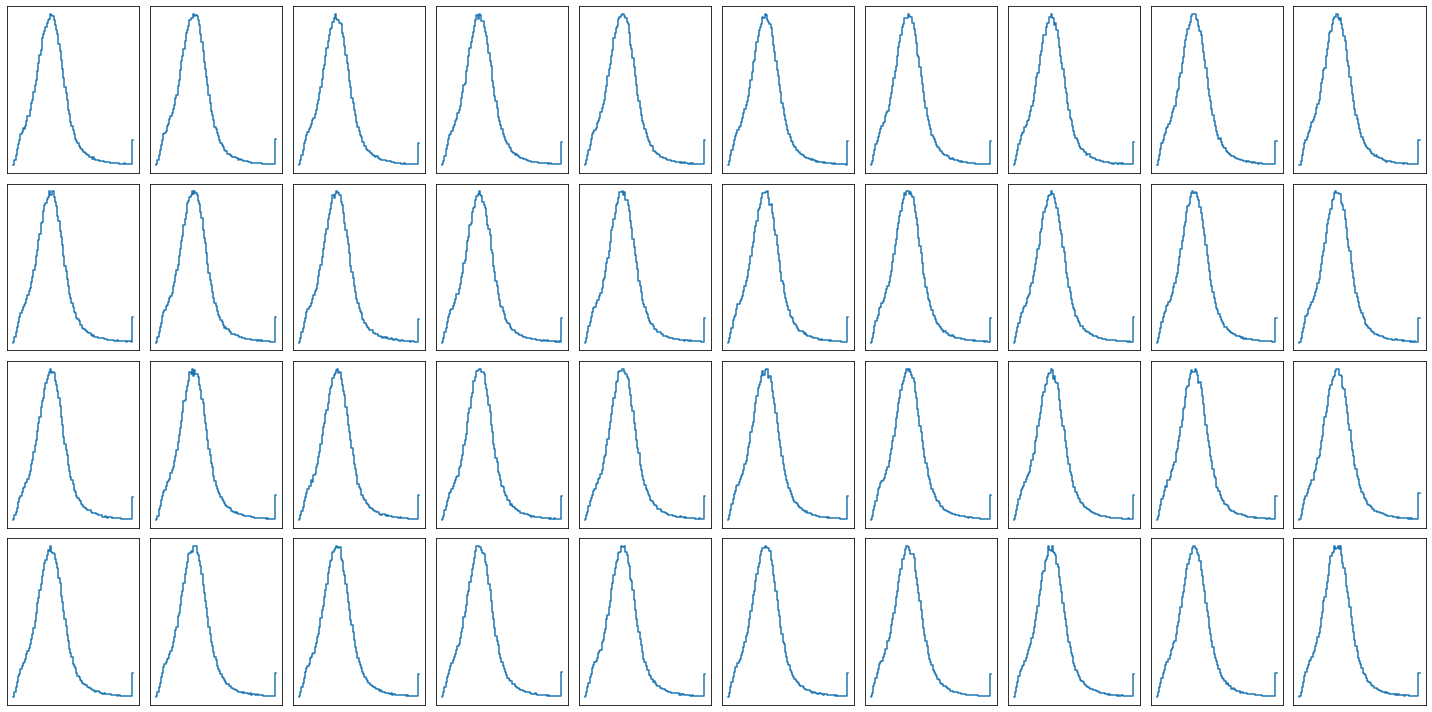

In [45]:
bins = np.arange(0,102)
fig, axes = plt.subplots(4, 10, figsize=(20,10))
axes = axes.flatten()

for i, ax in enumerate(axes):
    ax.step(bins, meRR_df[meRR_df['fromrun']==297178]['chargeInner_PXLayer_1_hist'].values[i])
    ax.set_xticks([])
    ax.set_yticks([])
    
plt.tight_layout()
plt.show()

At a first glance, the histograms look nearly identical. Notice that after bin 60, the histogram drops of to 0 and that the main feature of all of the histograms is the peak on the left hand side.

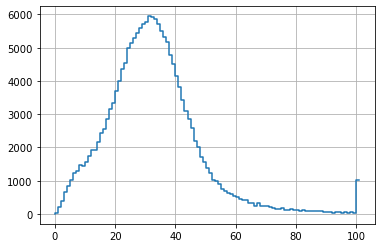

In [74]:
plt.step(np.arange(0,102), meRR_df[meRR_df['fromrun']==297178]['chargeInner_PXLayer_1_hist'].values[0])
plt.grid()

During testing of an anomaly detection approach done by Anoshree Gosh, a former member of the ML4DQM CMS development team, it was observed that, to characterize the behavior of these monitoring elements, it suffices to only consider those bins near the peak that is seen[1]. Following in her example, we will be choosing only the first 62 bins. This will shrink our dataset to a more manageable level, appropriate for the hardware limitations present in this project.

With this in mind, we can go ahead and create our training dataset from the reference run that is available in our data. With the current file being used, we only have the reference run 297178 available for that, but this suffices as it is relatively long run and so contains a substantial amount of statistics. Furthermore, this project is a proof of concept so, although further testing with more reference runs would be required for a more comprehensive evaluation of the anomaly detection approach used here, it is enough for our purposes.

In [233]:
X_train = np.stack(meRR_df[meRR_df['fromrun']==297178]['chargeInner_PXLayer_1_hist'].values)[:,:62]

In order to visualize the behavior and shape of the histogram along all of the lumisections, we can plot the data as a heatmap. Each row will correspond to a lumisection and each column will be a bin in the 62 bin wide histograms of our dataset.

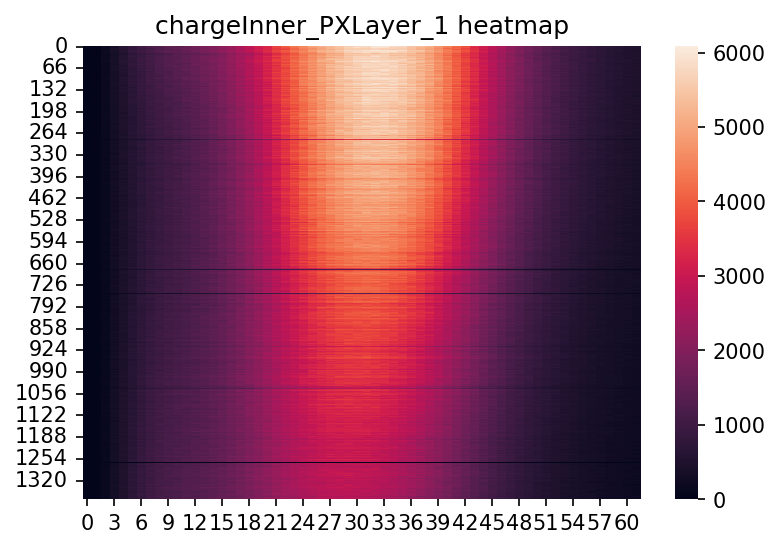

In [234]:
pltu.heatmap(X_train, title='chargeInner_PXLayer_1 heatmap', dpi=150)
plt.show()

We can see that a small subset of the lumisections in this dataset seem to be missing. However, this is an illusion as it is only an effect of the heatmap. In order for the autoencoder we will be build to converge and be able to reconstruct the data, and to avoid this issue with the heatmaps, we will normalize our dataset by having all of the histograms have an under them equal to unity.

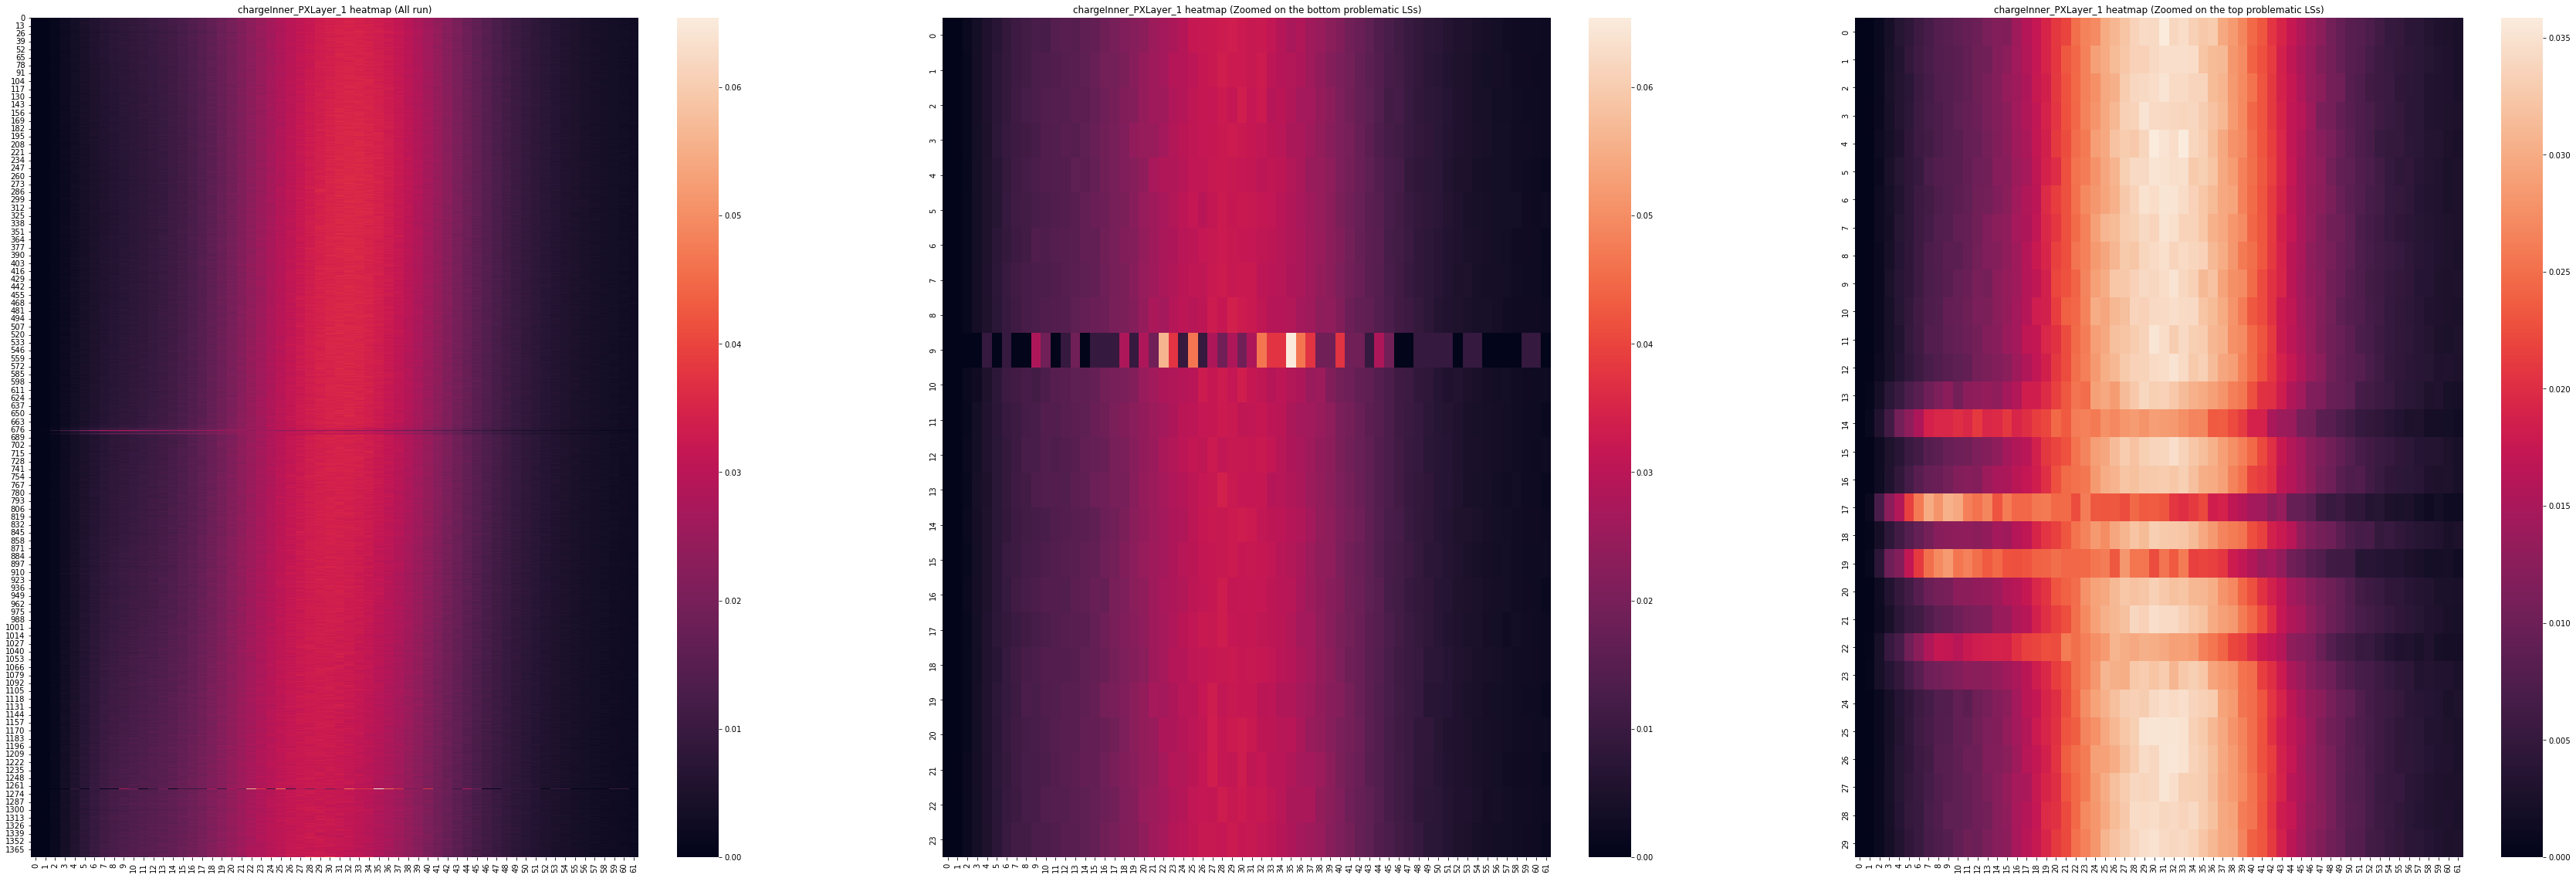

In [235]:
X_train_norm = datau.normalizeME(X_train)
fig, ax = plt.subplots(1, 3, figsize=(60,20))
ax[0] = pltu.heatmapsfig(X_train_norm, ax=ax[0], title='chargeInner_PXLayer_1 heatmap (All run)', dpi=150)
ax[1] = pltu.heatmapsfig(X_train_norm[1256:1280], ax=ax[1], title='chargeInner_PXLayer_1 heatmap (Zoomed on the bottom problematic LSs)', dpi=150)
ax[2] = pltu.heatmapsfig(X_train_norm[660:690], ax=ax[2], title='chargeInner_PXLayer_1 heatmap (Zoomed on the top problematic LSs)', dpi=150)
plt.show()

On the left hand side, we can see all of the training lumisections stacked and plotted as a histogram. As can be seen, when the dataset is normalized, we can appreciate that almost none of the lumisections have any problems. However, there are a couple of lumisection which appear to have some issue. In the heat map in the middle, we have zoomed in to the problematic lumisection that can be seen at around lumisection 1274. As we can see, it is just a single lumisection. Moreover, on the heat map on the right hand side, where we have zoomed on the problematic lumisections that can be seen near lumisection 676, we can observe that the number of lumisection here that have some issue is just 8. With the proportion of good lumisections to problematic lumisection being so large, we do not have to worry about using this dataset for training.

For completeness, we look at the shape of all of the histograms to have a better idea of how those problematic lumisections look like. Here, we have plotted all of the histograms. In this plot we can see that only three histograms show an large deviation from the general shape and that one of them, the brown one, is due to a small number of estries in the histogram (likely due in a decrease in trigger rate).

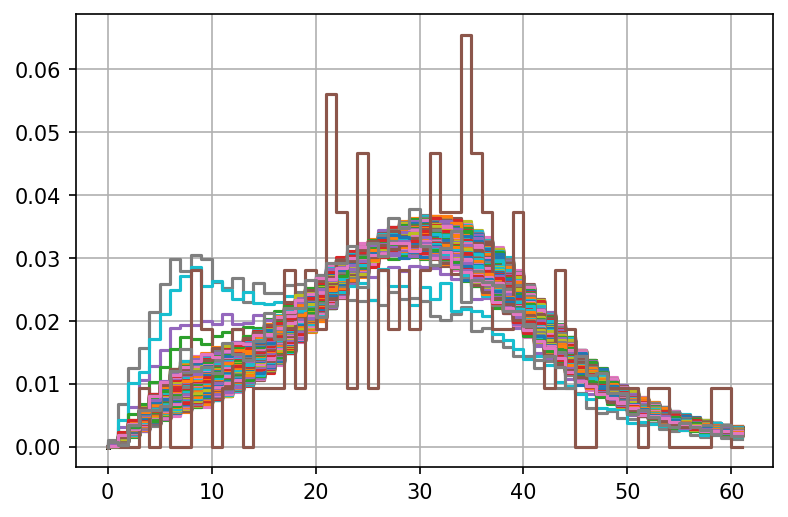

In [150]:
fig, ax = plt.subplots(dpi=150)
for train_hist in X_train_norm:
    ax.step(bins, train_hist)
plt.grid()

<h1><font color='blue'>Building and training the autoencoder</font></h1>

We use tensorflow to build our autoencoder. It's important to note that two versions of the autoencoder were used during testing and the one with the highest translational invariance (i.e. the one which was able to succesfully reconstruct the original histogram even if it is displaced) was chosen. The first first used is seen below. It is a simple fully connected neural network which uses LeakyReLU for all of its activation functions. 

In [153]:
class autoencoder(Model):
    def __init__(self):
        super(autoencoder, self).__init__()
        
        self.encoder_layer1 = Dense(32, name='encoder_layer1')
        self.leaky_relu1 = LeakyReLU(alpha=0.01, name='lrelu1')
        self.encoder_layer2 = Dense(12, name='encoder_layer2')
        self.leaky_relu2 = LeakyReLU(alpha=0.01, name='lrelu2')
        self.encoder_layer3 = Dense(8, name='encoder_layer3')
        self.leaky_relu3 = LeakyReLU(alpha=0.01, name='lrelu3')
        
        # Decoder
        self.decoder_layer1 = Dense(12, name='decoder_layer1')
        self.leaky_relu4 = LeakyReLU(alpha=0.01, name='lrelu4')
        self.decoder_layer2 = Dense(32, name='decoder_layer2')
        self.leaky_relu5 = LeakyReLU(alpha=0.01, name='lrelu5')
        self.decoder_output = Dense(62, activation='softmax', name='decoder_output')
    
    def call(self, inputs):
        # Passing through encoder
        x = self.encoder_layer1(inputs)
        x = self.leaky_relu1(x)
        x = self.encoder_layer2(x)
        x = self.leaky_relu2(x)
        encoded = self.encoder_layer3(x)
        encoded = self.leaky_relu3(encoded)
        
        # Passing through decoder
        x = self.decoder_layer1(encoded)
        x = self.leaky_relu4(x)
        x = self.decoder_layer2(x)
        x = self.leaky_relu5(x)
        decoded = self.decoder_output(x)
        
        return decoded

As a quick test of its performance and to see how translationally invariant it is, we can use it to reconstruct a particular run. To do this, we first train it using the reference run and then pass the target run through it. For the loss we will us the Kullback Leiber divergence and we will use adam as our optimizer.

In [175]:
ae_pxl1_old = autoencoder()
ae_pxl1_old.compile(optimizer='adam', loss=kullback_leibler_divergence)
ae_pxl1_old.build((None, 62))
ae_pxl1_old.summary()

Model: "autoencoder_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_layer1 (Dense)      multiple                  2016      
                                                                 
 lrelu1 (LeakyReLU)          multiple                  0         
                                                                 
 encoder_layer2 (Dense)      multiple                  396       
                                                                 
 lrelu2 (LeakyReLU)          multiple                  0         
                                                                 
 encoder_layer3 (Dense)      multiple                  104       
                                                                 
 lrelu3 (LeakyReLU)          multiple                  0         
                                                                 
 decoder_layer1 (Dense)      multiple                

In [166]:
# Segmenting the training data into validation and training.
X_train, X_val = train_test_split(X_train_norm, test_size=0.2, random_state=1)

In [176]:
%%time
history = ae_pxl1_old.fit(X_train, X_train, epochs=300, batch_size=128, validation_data=(X_val, X_val))
# CPU times: user 23.8 s, sys: 5.96 s, total: 29.8 s
# Wall time: 26 s

Epoch 1/300
9/9 [==============================] - 2s 36ms/step - loss: 0.2575 - val_loss: 0.2515
Epoch 2/300
9/9 [==============================] - 0s 9ms/step - loss: 0.2458 - val_loss: 0.2364
Epoch 3/300
9/9 [==============================] - 0s 9ms/step - loss: 0.2265 - val_loss: 0.2103
Epoch 4/300
9/9 [==============================] - 0s 11ms/step - loss: 0.1938 - val_loss: 0.1678
Epoch 5/300
9/9 [==============================] - 0s 9ms/step - loss: 0.1447 - val_loss: 0.1118
Epoch 6/300
9/9 [==============================] - 0s 9ms/step - loss: 0.0900 - val_loss: 0.0651
Epoch 7/300
9/9 [==============================] - 0s 9ms/step - loss: 0.0544 - val_loss: 0.0420
Epoch 8/300
9/9 [==============================] - 0s 9ms/step - loss: 0.0349 - val_loss: 0.0263
Epoch 9/300
9/9 [==============================] - 0s 9ms/step - loss: 0.0231 - val_loss: 0.0193
Epoch 10/300
9/9 [==============================] - 0s 9ms/step - loss: 0.0176 - val_loss: 0.0152
Epoch 11/300
9/9 [=========

9/9 [==============================] - 0s 9ms/step - loss: 5.6184e-04 - val_loss: 3.8213e-04
Epoch 162/300
9/9 [==============================] - 0s 9ms/step - loss: 5.5929e-04 - val_loss: 3.8184e-04
Epoch 163/300
9/9 [==============================] - 0s 9ms/step - loss: 5.5703e-04 - val_loss: 3.7828e-04
Epoch 164/300
9/9 [==============================] - 0s 9ms/step - loss: 5.5810e-04 - val_loss: 3.8031e-04
Epoch 165/300
9/9 [==============================] - 0s 9ms/step - loss: 5.5971e-04 - val_loss: 3.7839e-04
Epoch 166/300
9/9 [==============================] - 0s 9ms/step - loss: 5.5538e-04 - val_loss: 3.8060e-04
Epoch 167/300
9/9 [==============================] - 0s 9ms/step - loss: 5.5716e-04 - val_loss: 3.7530e-04
Epoch 168/300
9/9 [==============================] - 0s 9ms/step - loss: 5.5775e-04 - val_loss: 3.8044e-04
Epoch 169/300
9/9 [==============================] - 0s 9ms/step - loss: 5.5600e-04 - val_loss: 3.7312e-04
Epoch 170/300
9/9 [==============================] 

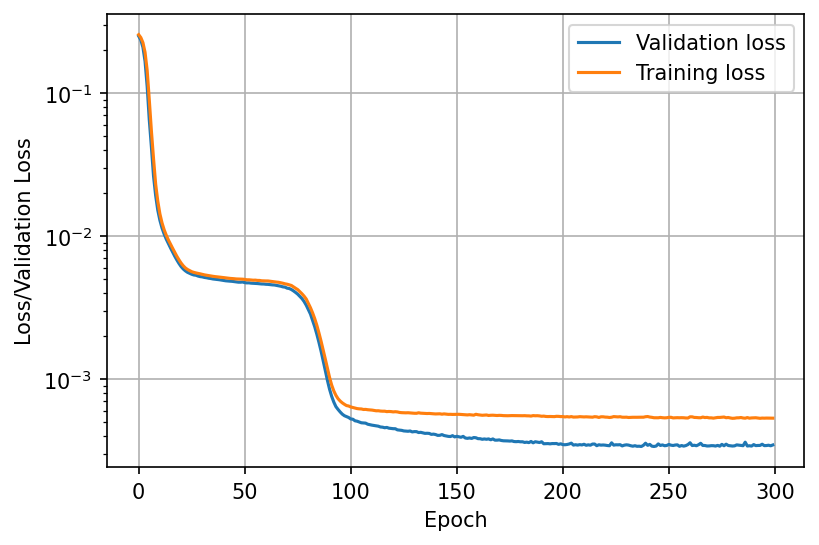

In [185]:
fig, ax = plt.subplots(dpi=150)
ax.plot(history.history['val_loss'], label='Validation loss')
ax.plot(history.history['loss'], label='Training loss')
ax.set_ylabel('Loss/Validation Loss')
ax.set_xlabel('Epoch')
ax.grid()
ax.set_yscale('log')
ax.legend()

plt.show()

From the loss plot we can see that after about 200 epochs, the model converges to a solution and does not seem to overfit to the data it was provided. Testing this model with a run it has never seen, we can get a quick sense of how translationally invariant it is.

In [179]:
run_target = 297050
X_test = np.stack(megood_df[megood_df['fromrun']==run_target]['chargeInner_PXLayer_1_hist'].values)[:,:62]
X_test = datau.normalizeME(X_test)

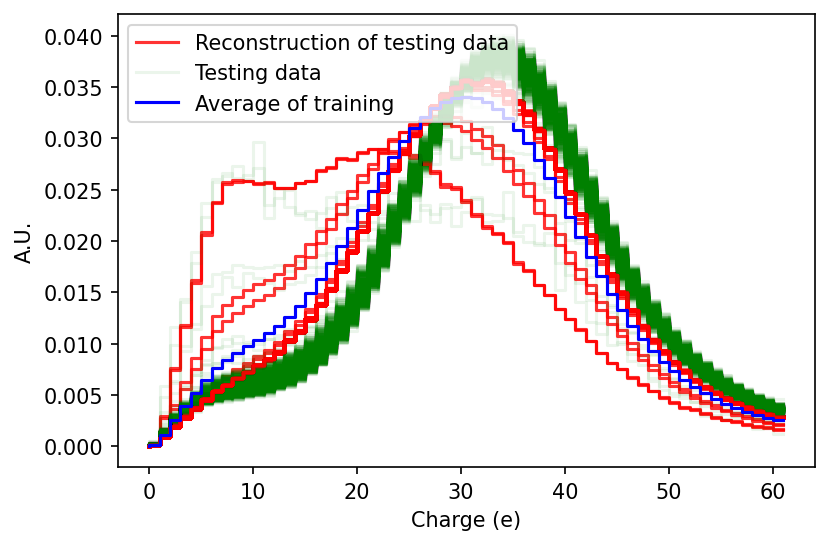

In [205]:
ae_reco = ae_pxl1_old(X_test)

fig, ax = plt.subplots(dpi=150)

for i, (reco, test) in enumerate(zip(ae_reco, X_test)):
    if i == 0:
        ax.step(bins, reco, color='red', alpha=0.8, label='Reconstruction of testing data')
        ax.step(bins, test, color='green', alpha=0.08, label='Testing data')
    ax.step(bins, reco, color='red', alpha=0.8)
    ax.step(bins, test, color='green', alpha=0.08)
ax.step(bins, X_train_norm.mean(axis=0), color='blue', alpha=1, label='Average of training')
ax.legend(loc='upper left')

ax.set_xlabel('Charge (e)')
ax.set_ylabel('A.U.')

plt.show()

We can see that the model is not so translationally invariant and this will mean that the reconstruction error will tend to be large. The problem with this is it will give the impression that there is a problem with the monitoring elements, when the only thing that is happening is that the histograms are translated with respect to the ones the model was trained on, and not that there is any real problem with the input run. Although the model doesn't have to be perfectly translationally invariant, its reconstructions should be able to approach the input run histograms as best as possible.

In order to resolve this issue, we use a different model which makes uses of a couple of convolutional layers. The model class is defined as such...

In [211]:
class autoencoderconv(Model):
    def __init__(self):
        super(autoencoderconv, self).__init__()
        
        # Convolutional layers
        self.leaky_relu1 = LeakyReLU(alpha=0.01, name='lrelu1')
        self.conv1 = Conv1D(32, 5, padding='same', name='conv1')
        self.leaky_relu2 = LeakyReLU(alpha=0.01, name='lrelu2')
        self.conv2 = Conv1D(32, 5, padding='same', name='conv2')
        self.leaky_relu3 = LeakyReLU(alpha=0.01, name='lrelu3')
        
        
        # Encoder
        self.encoder_layer1 = Dense(32, name='encoder_layer1')
        self.leaky_relu4 = LeakyReLU(alpha=0.01, name='lrelu4')
        self.encoder_layer2 = Dense(12, name='encoder_layer2')
        self.leaky_relu5 = LeakyReLU(alpha=0.01, name='lrelu5')
        self.encoder_layer3 = Dense(8, name='encoder_layer3')
        self.leaky_relu6 = LeakyReLU(alpha=0.01, name='lrelu7')
        
        # Decoder
        self.decoder_layer1 = Dense(12, name='decoder_layer1')
        self.leaky_relu7 = LeakyReLU(alpha=0.01, name='lrelu7')
        self.decoder_layer2 = Dense(32, name='decoder_layer2')
        self.leaky_relu8 = LeakyReLU(alpha=0.01, name='lrelu8')
        
        # Convolutional layers
        self.reshape = Reshape((32, 1))
        self.conv3 = Conv1D(32, 5, padding='same', name='conv3')
        self.flatten = Flatten()
        
        # Output
        self.decoder_output = Dense(62, activation='softmax', name='decoder_output')
    
    def call(self, inputs):
        # Add a dimension to input for the conv layer
        x = tf.expand_dims(inputs, axis=2)
        
        # Convolutional layer at the beginning
        x = self.conv1(x)
        x = self.leaky_relu1(x)
        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.flatten(x)
        
        # Passing through encoder
        x = self.encoder_layer1(x)
        x = self.leaky_relu3(x)
        x = self.encoder_layer2(x)
        x = self.leaky_relu4(x)
        x = self.encoder_layer3(x)
        x = self.leaky_relu5(x)
        
        # Passing through decoder
        x = self.decoder_layer1(x)
        x = self.leaky_relu6(x)
        x = self.decoder_layer2(x)
        x = self.leaky_relu7(x)
        
        
        x = self.reshape(x)
        x = self.conv3(x)
        x = self.leaky_relu8(x)
        x = self.flatten(x)
        x = self.decoder_output(x)
        
        return x

We now train this model the same way we trained the previous model.

In [214]:
ae_pxl1 = autoencoderconv()
ae_pxl1.compile(optimizer='adam', loss=kullback_leibler_divergence)
ae_pxl1.build((None, 62))
ae_pxl1.summary()

Model: "autoencoderconv_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lrelu1 (LeakyReLU)          multiple                  0         
                                                                 
 conv1 (Conv1D)              multiple                  192       
                                                                 
 lrelu2 (LeakyReLU)          multiple                  0         
                                                                 
 conv2 (Conv1D)              multiple                  5152      
                                                                 
 lrelu3 (LeakyReLU)          multiple                  0         
                                                                 
 encoder_layer1 (Dense)      multiple                  63520     
                                                                 
 lrelu4 (LeakyReLU)          multiple            

In [215]:
X_train, X_val = train_test_split(X_train_norm, test_size=0.2, random_state=1)

In [216]:
%%time
history = ae_pxl1.fit(X_train, X_train, epochs=150, batch_size=128, validation_data=(X_val, X_val))
# CPU times: user 43.2 s, sys: 6.99 s, total: 50.2 s
# Wall time: 30.8 s

Epoch 1/150
9/9 [==============================] - 3s 61ms/step - loss: 0.2551 - val_loss: 0.2360
Epoch 2/150
9/9 [==============================] - 0s 23ms/step - loss: 0.1774 - val_loss: 0.0624
Epoch 3/150
9/9 [==============================] - 0s 23ms/step - loss: 0.0479 - val_loss: 0.0200
Epoch 4/150
9/9 [==============================] - 0s 26ms/step - loss: 0.0211 - val_loss: 0.0143
Epoch 5/150
9/9 [==============================] - 0s 24ms/step - loss: 0.0127 - val_loss: 0.0099
Epoch 6/150
9/9 [==============================] - 0s 24ms/step - loss: 0.0092 - val_loss: 0.0078
Epoch 7/150
9/9 [==============================] - 0s 23ms/step - loss: 0.0076 - val_loss: 0.0068
Epoch 8/150
9/9 [==============================] - 0s 23ms/step - loss: 0.0067 - val_loss: 0.0063
Epoch 9/150
9/9 [==============================] - 0s 22ms/step - loss: 0.0063 - val_loss: 0.0059
Epoch 10/150
9/9 [==============================] - 0s 23ms/step - loss: 0.0060 - val_loss: 0.0058
Epoch 11/150
9/9 [=

Epoch 82/150
9/9 [==============================] - 0s 21ms/step - loss: 5.4474e-04 - val_loss: 3.3161e-04
Epoch 83/150
9/9 [==============================] - 0s 21ms/step - loss: 5.3418e-04 - val_loss: 3.3920e-04
Epoch 84/150
9/9 [==============================] - 0s 21ms/step - loss: 5.3141e-04 - val_loss: 3.3735e-04
Epoch 85/150
9/9 [==============================] - 0s 19ms/step - loss: 5.3514e-04 - val_loss: 3.3461e-04
Epoch 86/150
9/9 [==============================] - 0s 20ms/step - loss: 5.3675e-04 - val_loss: 3.2889e-04
Epoch 87/150
9/9 [==============================] - 0s 20ms/step - loss: 5.3221e-04 - val_loss: 3.3321e-04
Epoch 88/150
9/9 [==============================] - 0s 21ms/step - loss: 5.3141e-04 - val_loss: 3.2458e-04
Epoch 89/150
9/9 [==============================] - 0s 21ms/step - loss: 5.2803e-04 - val_loss: 3.2080e-04
Epoch 90/150
9/9 [==============================] - 0s 20ms/step - loss: 5.2963e-04 - val_loss: 3.3178e-04
Epoch 91/150
9/9 [===================

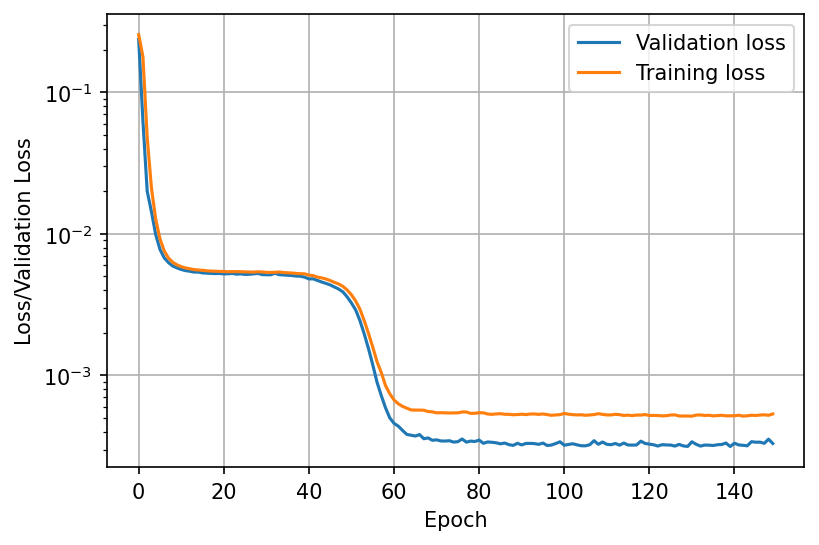

In [217]:
fig, ax = plt.subplots(dpi=150)
ax.plot(history.history['val_loss'], label='Validation loss')
ax.plot(history.history['loss'], label='Training loss')
ax.set_ylabel('Loss/Validation Loss')
ax.set_xlabel('Epoch')
ax.grid()
ax.set_yscale('log')
ax.legend()

plt.show()

We the new model trained, we go ahead and test it.

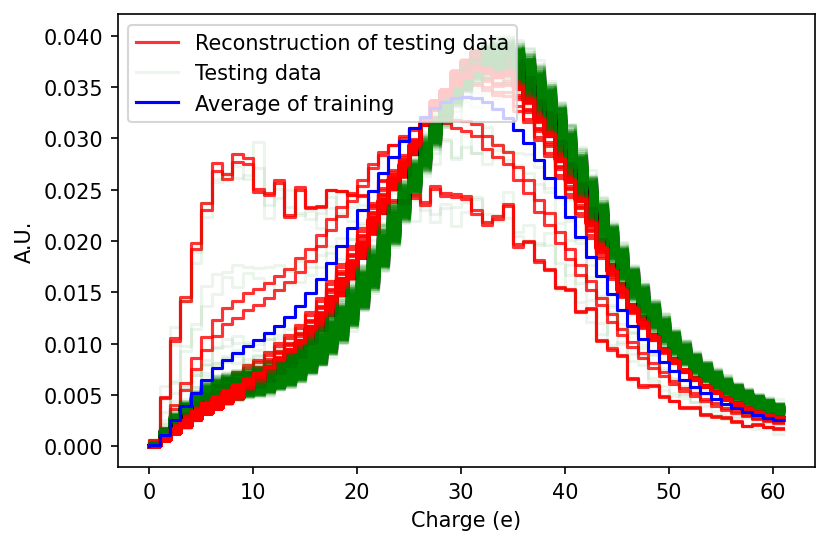

In [218]:
ae_reco = ae_pxl1(X_test)

fig, ax = plt.subplots(dpi=150)

for i, (reco, test) in enumerate(zip(ae_reco, X_test)):
    if i == 0:
        ax.step(bins, reco, color='red', alpha=0.8, label='Reconstruction of testing data')
        ax.step(bins, test, color='green', alpha=0.08, label='Testing data')
    ax.step(bins, reco, color='red', alpha=0.8)
    ax.step(bins, test, color='green', alpha=0.08)
ax.step(bins, X_train_norm.mean(axis=0), color='blue', alpha=1, label='Average of training')
ax.legend(loc='upper left')

ax.set_xlabel('Charge (e)')
ax.set_ylabel('A.U.')

plt.show()

As we can see, this new model performs better in terms of translational invariance. However, it is also evident that it is not perfect as the reconstructions are not completely alligned with the test data. This, however, is acceptable: because we intend to build an autoencoder ensemble out of this base model, the model itself needs to be as simple as possible while still performing well. Moreover, while the peak of the histograms might shift and the lumisection is still considered good, a too large shift would be problematic, so our model needs to have some limitations in terms of its invariance to shifts in the histograms. To get an idea of the scale of the KL error here, we check the maximum, minimum, mean and standard deviation of the reconstructions.

In [219]:
KL = np.array(kullback_leibler_divergence(ae_reco, X_test))

print(
    '''
        Max KL: {}
        Min KL: {}
        Mean KL: {}
        STD of KL: {}
    '''.format(KL.max(),
              KL.min(),
              KL.mean(),
              KL.std()
              )
)


        Max KL: 0.016172311628614627
        Min KL: 0.003995997803264687
        Mean KL: 0.009773973631198331
        STD of KL: 0.0029717984762722503
    


<h1><font color='blue'> Building and Training the Autoencoder Ensemble </font></h1>

We now proceed to build the autoencoder ensemble out of the second model we developed. For this, we use dictionary comprehension and the list of the monitoring element names to build a dictionary of autoencoders.

In [220]:
# Function which returns autoencode instance
def create_ae():
    return autoencoderconv()
ensemble = {name + '_AE': create_ae() for name in monitoring_elems}

The names of our autoencoders are the following:

In [391]:
list(ensemble.keys())

['chargeInner_PXLayer_1_AE',
 'chargeInner_PXLayer_2_AE',
 'chargeInner_PXLayer_3_AE',
 'chargeInner_PXLayer_4_AE',
 'chargeOuter_PXLayer_1_AE',
 'chargeOuter_PXLayer_2_AE',
 'chargeOuter_PXLayer_3_AE',
 'chargeOuter_PXLayer_4_AE',
 'charge_PXDisk_+1_AE',
 'charge_PXDisk_+2_AE',
 'charge_PXDisk_+3_AE',
 'charge_PXDisk_-1_AE',
 'charge_PXDisk_-2_AE',
 'charge_PXDisk_-3_AE',
 'num_clusters_ontrack_PXBarrel_AE',
 'num_clusters_ontrack_PXForward_AE']

In [227]:
print('''
    Number of training datasets (one for each AE/ME type): {}
    Number of datapoints/LSs: {}
    Number of features/bins: {}
    '''.format(Xs_train_norm.shape[0],
              Xs_train_norm.shape[1],
              Xs_train_norm.shape[2])
)


    Number of training datasets (one for each AE/ME type): 16
    Number of datapoints/LSs: 1378
    Number of features/bins: 62
    


We can take a look at the heatmaps for all the monitoring elements in order to get a sense of how the histograms for each look. In order to do this, we construct the training dataset in order to visualize it and then, from that, build the heatmaps.

In [229]:
Xs_train = np.array([np.stack(meRR_df[meRR_df['fromrun']==297178][me+'_hist'].values) for me in monitoring_elems])[:,:,:62]
Xs_train_norm = datau.normalizeMEs(Xs_train)

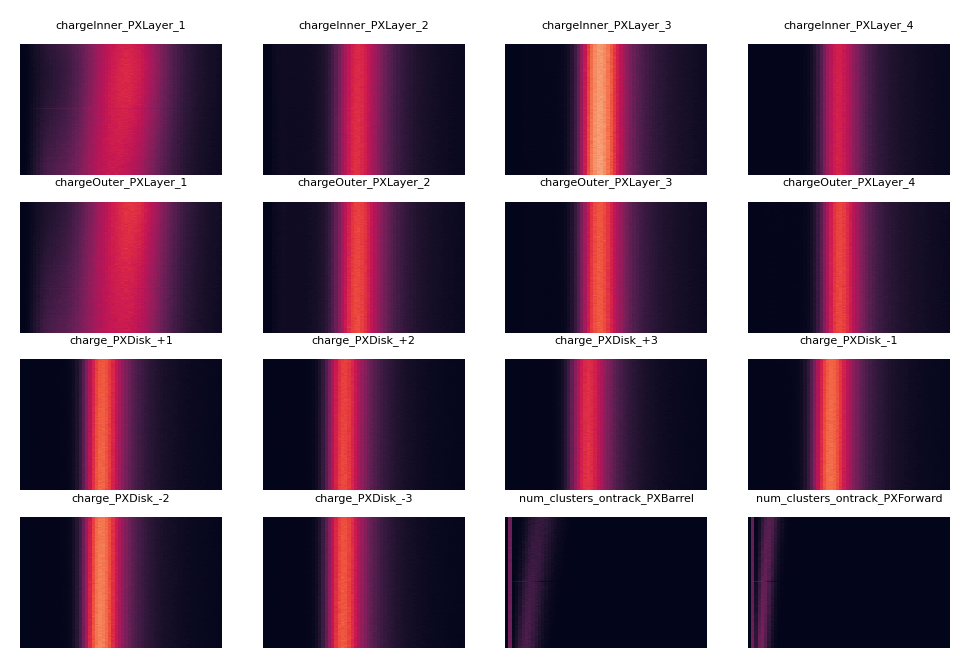

In [237]:
pltu.heatmaps(Xs_train_norm, monitoring_elems, dpi=200)

With the constructed ensemble, we compile and build all of the models and then proceed to train all of them on the same reference run we were using before. Note that each autoencoder will only train on a particular type of monitoring element (i.e. a particular type of histogram), so each of them will specialize in reconstructing only one type of histogram. In addition to this, all the model are trained using the KL divergence as the loss and the optimizer user is adam.

In [241]:
for me in monitoring_elems:
    ensemble[me+'_AE'].compile(optimizer='adam', loss=kullback_leibler_divergence)
    ensemble[me+'_AE'].build((None,62))

In [242]:
%%time
histories = []
for i, me in enumerate(monitoring_elems):
    X_train, X_val = train_test_split(Xs_train_norm[i], test_size=0.2, random_state=1)
    histories.append(ensemble[me+'_AE'].fit(X_train, X_train, epochs=150, batch_size=128, validation_data=(X_val, X_val)))
# CPU times: user 11min 37s, sys: 1min 53s, total: 13min 30s
# Wall time: 8min 33s

Epoch 1/150
9/9 [==============================] - 4s 53ms/step - loss: 0.0020 - val_loss: 8.4318e-04
Epoch 2/150
9/9 [==============================] - 0s 21ms/step - loss: 9.4904e-04 - val_loss: 4.6893e-04
Epoch 3/150
9/9 [==============================] - 0s 21ms/step - loss: 6.8456e-04 - val_loss: 4.3507e-04
Epoch 4/150
9/9 [==============================] - 0s 22ms/step - loss: 5.7449e-04 - val_loss: 3.3799e-04
Epoch 5/150
9/9 [==============================] - 0s 23ms/step - loss: 5.3077e-04 - val_loss: 3.2690e-04
Epoch 6/150
9/9 [==============================] - 0s 22ms/step - loss: 5.1516e-04 - val_loss: 3.0657e-04
Epoch 7/150
9/9 [==============================] - 0s 22ms/step - loss: 5.0815e-04 - val_loss: 3.0880e-04
Epoch 8/150
9/9 [==============================] - 0s 23ms/step - loss: 5.1210e-04 - val_loss: 3.1072e-04
Epoch 9/150
9/9 [==============================] - 0s 22ms/step - loss: 5.1033e-04 - val_loss: 3.0711e-04
Epoch 10/150
9/9 [==============================] 

9/9 [==============================] - 0s 24ms/step - loss: 0.0013 - val_loss: 6.5381e-04
Epoch 4/150
9/9 [==============================] - 0s 24ms/step - loss: 9.9936e-04 - val_loss: 5.5919e-04
Epoch 5/150
9/9 [==============================] - 0s 23ms/step - loss: 8.6541e-04 - val_loss: 5.7106e-04
Epoch 6/150
9/9 [==============================] - 0s 23ms/step - loss: 8.2017e-04 - val_loss: 5.5103e-04
Epoch 7/150
9/9 [==============================] - 0s 23ms/step - loss: 8.0504e-04 - val_loss: 5.4245e-04
Epoch 8/150
9/9 [==============================] - 0s 25ms/step - loss: 8.0282e-04 - val_loss: 5.4074e-04
Epoch 9/150
9/9 [==============================] - 0s 24ms/step - loss: 8.0098e-04 - val_loss: 5.4115e-04
Epoch 10/150
9/9 [==============================] - 0s 22ms/step - loss: 7.9691e-04 - val_loss: 5.4199e-04
Epoch 11/150
9/9 [==============================] - 0s 22ms/step - loss: 7.9264e-04 - val_loss: 5.3281e-04
Epoch 12/150
9/9 [==============================] - 0s 22ms/

Epoch 80/150
9/9 [==============================] - 0s 22ms/step - loss: 7.9874e-04 - val_loss: 5.4602e-04
Epoch 81/150
9/9 [==============================] - 0s 21ms/step - loss: 7.9482e-04 - val_loss: 5.4805e-04
Epoch 82/150
9/9 [==============================] - 2s 188ms/step - loss: 8.0098e-04 - val_loss: 5.4541e-04
Epoch 83/150
9/9 [==============================] - 2s 195ms/step - loss: 7.9922e-04 - val_loss: 5.3469e-04
Epoch 84/150
9/9 [==============================] - 0s 21ms/step - loss: 8.0202e-04 - val_loss: 5.5789e-04
Epoch 85/150
9/9 [==============================] - 0s 20ms/step - loss: 8.0720e-04 - val_loss: 5.3799e-04
Epoch 86/150
9/9 [==============================] - 0s 20ms/step - loss: 8.0477e-04 - val_loss: 5.3267e-04
Epoch 87/150
9/9 [==============================] - 0s 20ms/step - loss: 7.8760e-04 - val_loss: 5.3471e-04
Epoch 88/150
9/9 [==============================] - 0s 21ms/step - loss: 7.9407e-04 - val_loss: 5.4831e-04
Epoch 89/150
9/9 [=================

9/9 [==============================] - 0s 22ms/step - loss: 8.0584e-04 - val_loss: 4.7045e-04
Epoch 83/150
9/9 [==============================] - 0s 22ms/step - loss: 7.9445e-04 - val_loss: 4.6041e-04
Epoch 84/150
9/9 [==============================] - 0s 22ms/step - loss: 7.9358e-04 - val_loss: 4.7766e-04
Epoch 85/150
9/9 [==============================] - 0s 24ms/step - loss: 7.8851e-04 - val_loss: 4.5112e-04
Epoch 86/150
9/9 [==============================] - 0s 22ms/step - loss: 7.9244e-04 - val_loss: 4.5264e-04
Epoch 87/150
9/9 [==============================] - 0s 21ms/step - loss: 7.9575e-04 - val_loss: 4.5504e-04
Epoch 88/150
9/9 [==============================] - 0s 20ms/step - loss: 8.0179e-04 - val_loss: 4.7596e-04
Epoch 89/150
9/9 [==============================] - 0s 20ms/step - loss: 8.0824e-04 - val_loss: 4.5019e-04
Epoch 90/150
9/9 [==============================] - 0s 21ms/step - loss: 8.0857e-04 - val_loss: 4.6353e-04
Epoch 91/150
9/9 [==============================] 

9/9 [==============================] - 0s 20ms/step - loss: 9.4758e-04 - val_loss: 5.5388e-04
Epoch 85/150
9/9 [==============================] - 0s 20ms/step - loss: 9.4361e-04 - val_loss: 5.4378e-04
Epoch 86/150
9/9 [==============================] - 0s 20ms/step - loss: 9.4870e-04 - val_loss: 5.0271e-04
Epoch 87/150
9/9 [==============================] - 0s 21ms/step - loss: 9.3557e-04 - val_loss: 5.0465e-04
Epoch 88/150
9/9 [==============================] - 0s 21ms/step - loss: 9.4086e-04 - val_loss: 5.1343e-04
Epoch 89/150
9/9 [==============================] - 0s 23ms/step - loss: 9.3231e-04 - val_loss: 5.2864e-04
Epoch 90/150
9/9 [==============================] - 0s 22ms/step - loss: 9.4381e-04 - val_loss: 4.9498e-04
Epoch 91/150
9/9 [==============================] - 0s 20ms/step - loss: 9.4032e-04 - val_loss: 5.1467e-04
Epoch 92/150
9/9 [==============================] - 0s 21ms/step - loss: 9.3667e-04 - val_loss: 5.1688e-04
Epoch 93/150
9/9 [==============================] 

9/9 [==============================] - 0s 20ms/step - loss: 5.1215e-04 - val_loss: 3.0482e-04
Epoch 87/150
9/9 [==============================] - 0s 23ms/step - loss: 5.1505e-04 - val_loss: 3.2073e-04
Epoch 88/150
9/9 [==============================] - 0s 21ms/step - loss: 5.2227e-04 - val_loss: 3.1090e-04
Epoch 89/150
9/9 [==============================] - 0s 22ms/step - loss: 5.1609e-04 - val_loss: 3.4702e-04
Epoch 90/150
9/9 [==============================] - 0s 22ms/step - loss: 5.2666e-04 - val_loss: 3.1749e-04
Epoch 91/150
9/9 [==============================] - 0s 21ms/step - loss: 5.1419e-04 - val_loss: 3.1441e-04
Epoch 92/150
9/9 [==============================] - 0s 20ms/step - loss: 5.1383e-04 - val_loss: 3.2176e-04
Epoch 93/150
9/9 [==============================] - 0s 20ms/step - loss: 5.1501e-04 - val_loss: 3.2040e-04
Epoch 94/150
9/9 [==============================] - 0s 21ms/step - loss: 5.1800e-04 - val_loss: 3.2483e-04
Epoch 95/150
9/9 [==============================] 

9/9 [==============================] - 0s 20ms/step - loss: 8.6913e-04 - val_loss: 5.6455e-04
Epoch 89/150
9/9 [==============================] - 0s 22ms/step - loss: 8.6259e-04 - val_loss: 5.6085e-04
Epoch 90/150
9/9 [==============================] - 0s 21ms/step - loss: 8.8239e-04 - val_loss: 5.6145e-04
Epoch 91/150
9/9 [==============================] - 0s 21ms/step - loss: 8.6877e-04 - val_loss: 5.5351e-04
Epoch 92/150
9/9 [==============================] - 0s 21ms/step - loss: 8.6229e-04 - val_loss: 5.6073e-04
Epoch 93/150
9/9 [==============================] - 0s 21ms/step - loss: 8.6323e-04 - val_loss: 5.6694e-04
Epoch 94/150
9/9 [==============================] - 0s 21ms/step - loss: 8.5913e-04 - val_loss: 5.6216e-04
Epoch 95/150
9/9 [==============================] - 0s 22ms/step - loss: 8.6787e-04 - val_loss: 5.7730e-04
Epoch 96/150
9/9 [==============================] - 0s 22ms/step - loss: 8.6110e-04 - val_loss: 5.5870e-04
Epoch 97/150
9/9 [==============================] 

9/9 [==============================] - 0s 22ms/step - loss: 7.4446e-04 - val_loss: 4.4614e-04
Epoch 91/150
9/9 [==============================] - 0s 21ms/step - loss: 7.3158e-04 - val_loss: 4.4571e-04
Epoch 92/150
9/9 [==============================] - 0s 22ms/step - loss: 7.2881e-04 - val_loss: 4.4909e-04
Epoch 93/150
9/9 [==============================] - 0s 20ms/step - loss: 7.3060e-04 - val_loss: 4.6124e-04
Epoch 94/150
9/9 [==============================] - 0s 20ms/step - loss: 7.3531e-04 - val_loss: 4.4930e-04
Epoch 95/150
9/9 [==============================] - 0s 21ms/step - loss: 7.3679e-04 - val_loss: 4.7647e-04
Epoch 96/150
9/9 [==============================] - 0s 22ms/step - loss: 7.5850e-04 - val_loss: 4.7506e-04
Epoch 97/150
9/9 [==============================] - 0s 23ms/step - loss: 7.3964e-04 - val_loss: 4.7846e-04
Epoch 98/150
9/9 [==============================] - 0s 23ms/step - loss: 7.4289e-04 - val_loss: 5.0011e-04
Epoch 99/150
9/9 [==============================] 

9/9 [==============================] - 0s 20ms/step - loss: 8.4638e-04 - val_loss: 5.2300e-04
Epoch 93/150
9/9 [==============================] - 0s 21ms/step - loss: 8.3820e-04 - val_loss: 5.1975e-04
Epoch 94/150
9/9 [==============================] - 0s 21ms/step - loss: 8.3656e-04 - val_loss: 5.4238e-04
Epoch 95/150
9/9 [==============================] - 0s 21ms/step - loss: 8.4812e-04 - val_loss: 5.3074e-04
Epoch 96/150
9/9 [==============================] - 0s 21ms/step - loss: 8.5057e-04 - val_loss: 5.2826e-04
Epoch 97/150
9/9 [==============================] - 0s 21ms/step - loss: 8.5207e-04 - val_loss: 5.1936e-04
Epoch 98/150
9/9 [==============================] - 0s 20ms/step - loss: 8.3674e-04 - val_loss: 5.1290e-04
Epoch 99/150
9/9 [==============================] - 0s 20ms/step - loss: 8.4905e-04 - val_loss: 5.2925e-04
Epoch 100/150
9/9 [==============================] - 0s 21ms/step - loss: 8.3945e-04 - val_loss: 5.4475e-04
Epoch 101/150
9/9 [==============================

9/9 [==============================] - 0s 22ms/step - loss: 8.9927e-04 - val_loss: 6.0230e-04
Epoch 95/150
9/9 [==============================] - 0s 21ms/step - loss: 8.9639e-04 - val_loss: 6.1978e-04
Epoch 96/150
9/9 [==============================] - 0s 20ms/step - loss: 9.0073e-04 - val_loss: 6.1664e-04
Epoch 97/150
9/9 [==============================] - 0s 20ms/step - loss: 8.9278e-04 - val_loss: 6.1507e-04
Epoch 98/150
9/9 [==============================] - 0s 21ms/step - loss: 8.9061e-04 - val_loss: 5.9533e-04
Epoch 99/150
9/9 [==============================] - 0s 22ms/step - loss: 8.9256e-04 - val_loss: 6.1063e-04
Epoch 100/150
9/9 [==============================] - 0s 22ms/step - loss: 8.9113e-04 - val_loss: 6.0106e-04
Epoch 101/150
9/9 [==============================] - 0s 23ms/step - loss: 8.9588e-04 - val_loss: 6.1178e-04
Epoch 102/150
9/9 [==============================] - 0s 21ms/step - loss: 8.9909e-04 - val_loss: 6.0531e-04
Epoch 103/150
9/9 [============================

9/9 [==============================] - 0s 20ms/step - loss: 9.8051e-04 - val_loss: 6.8842e-04
Epoch 97/150
9/9 [==============================] - 0s 21ms/step - loss: 9.7217e-04 - val_loss: 6.7460e-04
Epoch 98/150
9/9 [==============================] - 0s 21ms/step - loss: 9.7653e-04 - val_loss: 7.3783e-04
Epoch 99/150
9/9 [==============================] - 0s 21ms/step - loss: 9.9410e-04 - val_loss: 7.0181e-04
Epoch 100/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0010 - val_loss: 6.6945e-04
Epoch 101/150
9/9 [==============================] - 0s 20ms/step - loss: 9.8692e-04 - val_loss: 6.8659e-04
Epoch 102/150
9/9 [==============================] - 0s 22ms/step - loss: 9.7413e-04 - val_loss: 6.8031e-04
Epoch 103/150
9/9 [==============================] - 0s 21ms/step - loss: 9.7842e-04 - val_loss: 6.9342e-04
Epoch 104/150
9/9 [==============================] - 0s 21ms/step - loss: 9.7490e-04 - val_loss: 6.7969e-04
Epoch 105/150
9/9 [==============================

9/9 [==============================] - 0s 22ms/step - loss: 0.0011 - val_loss: 6.4574e-04
Epoch 103/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 6.5822e-04
Epoch 104/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 6.4582e-04
Epoch 105/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 6.6122e-04
Epoch 106/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0011 - val_loss: 6.5923e-04
Epoch 107/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 6.5327e-04
Epoch 108/150
9/9 [==============================] - 0s 23ms/step - loss: 0.0011 - val_loss: 6.5923e-04
Epoch 109/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 6.7444e-04
Epoch 110/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0011 - val_loss: 6.7427e-04
Epoch 111/150
9/9 [==============================] - 0s 20ms/step - loss: 0.00

Epoch 30/150
9/9 [==============================] - 0s 21ms/step - loss: 7.6697e-04 - val_loss: 5.3180e-04
Epoch 31/150
9/9 [==============================] - 0s 20ms/step - loss: 7.6663e-04 - val_loss: 5.3842e-04
Epoch 32/150
9/9 [==============================] - 0s 21ms/step - loss: 7.7968e-04 - val_loss: 5.5428e-04
Epoch 33/150
9/9 [==============================] - 0s 21ms/step - loss: 7.8534e-04 - val_loss: 5.4738e-04
Epoch 34/150
9/9 [==============================] - 0s 22ms/step - loss: 7.8036e-04 - val_loss: 5.5554e-04
Epoch 35/150
9/9 [==============================] - 0s 21ms/step - loss: 7.8255e-04 - val_loss: 5.4894e-04
Epoch 36/150
9/9 [==============================] - 0s 21ms/step - loss: 7.7738e-04 - val_loss: 5.3879e-04
Epoch 37/150
9/9 [==============================] - 0s 20ms/step - loss: 7.7187e-04 - val_loss: 5.4312e-04
Epoch 38/150
9/9 [==============================] - 0s 20ms/step - loss: 7.8496e-04 - val_loss: 5.4728e-04
Epoch 39/150
9/9 [===================

9/9 [==============================] - 0s 22ms/step - loss: 8.0191e-04 - val_loss: 5.8235e-04
Epoch 33/150
9/9 [==============================] - 0s 22ms/step - loss: 8.0622e-04 - val_loss: 6.0516e-04
Epoch 34/150
9/9 [==============================] - 0s 22ms/step - loss: 8.0516e-04 - val_loss: 5.8892e-04
Epoch 35/150
9/9 [==============================] - 0s 21ms/step - loss: 8.0621e-04 - val_loss: 5.8331e-04
Epoch 36/150
9/9 [==============================] - 0s 20ms/step - loss: 8.0251e-04 - val_loss: 5.7903e-04
Epoch 37/150
9/9 [==============================] - 0s 22ms/step - loss: 8.0832e-04 - val_loss: 5.9724e-04
Epoch 38/150
9/9 [==============================] - 0s 21ms/step - loss: 8.3416e-04 - val_loss: 5.9593e-04
Epoch 39/150
9/9 [==============================] - 0s 22ms/step - loss: 8.0950e-04 - val_loss: 5.7452e-04
Epoch 40/150
9/9 [==============================] - 0s 23ms/step - loss: 8.0054e-04 - val_loss: 5.7132e-04
Epoch 41/150
9/9 [==============================] 

9/9 [==============================] - 0s 20ms/step - loss: 9.6485e-04 - val_loss: 6.4824e-04
Epoch 35/150
9/9 [==============================] - 0s 20ms/step - loss: 9.6452e-04 - val_loss: 6.5001e-04
Epoch 36/150
9/9 [==============================] - 0s 21ms/step - loss: 9.6213e-04 - val_loss: 6.9261e-04
Epoch 37/150
9/9 [==============================] - 0s 22ms/step - loss: 9.8704e-04 - val_loss: 6.5818e-04
Epoch 38/150
9/9 [==============================] - 0s 21ms/step - loss: 9.7862e-04 - val_loss: 6.5370e-04
Epoch 39/150
9/9 [==============================] - 0s 22ms/step - loss: 9.7261e-04 - val_loss: 6.4729e-04
Epoch 40/150
9/9 [==============================] - 0s 22ms/step - loss: 9.6634e-04 - val_loss: 6.6364e-04
Epoch 41/150
9/9 [==============================] - 0s 20ms/step - loss: 9.6821e-04 - val_loss: 6.5650e-04
Epoch 42/150
9/9 [==============================] - 0s 20ms/step - loss: 9.7062e-04 - val_loss: 6.5705e-04
Epoch 43/150
9/9 [==============================] 

9/9 [==============================] - 0s 21ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 40/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0058 - val_loss: 0.0058
Epoch 41/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 42/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 43/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0056
Epoch 44/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 45/150
9/9 [==============================] - 0s 22ms/step - loss: 0.0057 - val_loss: 0.0057
Epoch 46/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 47/150
9/9 [==============================] - 0s 24ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 48/150
9/9 [==============================] - 0s 22ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 49/150
9/9 [=====

9/9 [==============================] - 0s 21ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 54/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 55/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 56/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 57/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 58/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 59/150
9/9 [==============================] - 0s 21ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 60/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0036 - val_loss: 0.0033
Epoch 61/150
9/9 [==============================] - 0s 22ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 62/150
9/9 [==============================] - 0s 20ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 63/150
9/9 [=====

In [243]:
# Optional: Saving the model
for ME_name in monitoring_elems:
    model_path = f'./models/AEConvEnsemble_{ME_name}'
    ensemble[ME_name + '_AE'].save(model_path, save_format='tf')

2023-11-15 03:05:07.788122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:08.416386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeInner_PXLayer_1/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeInner_PXLayer_1/assets
2023-11-15 03:05:12.511452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:13.096099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeInner_PXLayer_2/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeInner_PXLayer_2/assets
2023-11-15 03:05:18.823195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:19.439374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeInner_PXLayer_3/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeInner_PXLayer_3/assets
2023-11-15 03:05:23.421577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:24.024203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeInner_PXLayer_4/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeInner_PXLayer_4/assets
2023-11-15 03:05:29.284679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:29.856265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeOuter_PXLayer_1/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeOuter_PXLayer_1/assets
2023-11-15 03:05:33.697484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:34.273292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeOuter_PXLayer_2/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeOuter_PXLayer_2/assets
2023-11-15 03:05:37.612479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:38.176562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeOuter_PXLayer_3/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeOuter_PXLayer_3/assets
2023-11-15 03:05:43.517853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:44.088093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeOuter_PXLayer_4/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_chargeOuter_PXLayer_4/assets
2023-11-15 03:05:49.017461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:49.581355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_+1/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_+1/assets
2023-11-15 03:05:54.688169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:55.266349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_+2/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_+2/assets
2023-11-15 03:05:58.591440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:05:59.151894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_+3/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_+3/assets
2023-11-15 03:06:02.741660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:06:03.339175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_-1/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_-1/assets
2023-11-15 03:06:09.161459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:06:09.729055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_-2/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_-2/assets
2023-11-15 03:06:13.295416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:06:13.844625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_-3/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_charge_PXDisk_-3/assets
2023-11-15 03:06:18.804508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:06:19.388505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_num_clusters_ontrack_PXBarrel/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_num_clusters_ontrack_PXBarrel/assets
2023-11-15 03:06:22.881892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]
2023-11-15 03:06:23.453355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_num_clusters_ontrack_PXForward/assets


INFO:tensorflow:Assets written to: ./models/AEConvEnsemble_num_clusters_ontrack_PXForward/assets


We now test the ensemble by having it reconstruct a good run which was certified using the reference run the model was trained on. Similar to what we did before, we first get our testing dataset, normalize it, and then run it through the trained models.

In [244]:
run_target = 297050
Xs_test = np.array([np.stack(megood_df[megood_df['fromrun']==run_target][me+'_hist'].values) for me in monitoring_elems])[:,:,:62]
Xs_test_norm = datau.normalizeMEs(Xs_test)

In [245]:
recos = []
for i, (key, AE) in enumerate(ensemble.items()):
    recos.append(AE(Xs_test_norm[i]))
recos = np.array(recos)

We make the heatmap of the original data and the reconstruction for all of the monitoring elements in order to get a general idea of how the did.

In [268]:
print('Test data...')
pltu.heatmaps(Xs_test_norm, monitoring_elems, dpi=200)

print('\n Reconstructed data...')
pltu.heatmaps(recos, monitoring_elems, dpi=200)

Test data...



 Reconstructed data...


From these, we can see that the model did well at reconstructing the monitoring elements. To quanity how good the model did at reconstructing this good data, we can use the KL divergence.

In [254]:
results = {'MEname': [], 'Max KL': [], 'Min KL': [], 'Mean KL': [], 'STD of KL': []}

# Loop over the monitoring elements
for i, MEname in enumerate(monitoring_elems):
    KL_test = np.array(kullback_leibler_divergence(recos[i], X_test[i]))
    results['MEname'].append(MEname)
    results['Max KL'].append(KL_test.max())
    results['Min KL'].append(KL_test.min())
    results['Mean KL'].append(KL_test.mean())
    results['STD of KL'].append(KL_test.std())

results_df = pd.DataFrame(results)
results_df

MEname    Max KL    Min KL   Mean KL  STD of KL
0            chargeInner_PXLayer_1  0.386000  0.021883  0.024900   0.019968
1            chargeInner_PXLayer_2  0.127368  0.105321  0.110382   0.002288
2            chargeInner_PXLayer_3  0.189770  0.188911  0.189136   0.000092
3            chargeInner_PXLayer_4  0.241979  0.240442  0.240960   0.000186
4            chargeOuter_PXLayer_1  0.392430  0.014678  0.027227   0.024035
5            chargeOuter_PXLayer_2  0.128950  0.124649  0.125542   0.000425
6            chargeOuter_PXLayer_3  0.187611  0.186638  0.186907   0.000112
7            chargeOuter_PXLayer_4  0.217425  0.217092  0.217259   0.000052
8                 charge_PXDisk_+1  0.423855  0.414092  0.416030   0.001049
9                 charge_PXDisk_+2  0.431407  0.427181  0.427982   0.000390
10                charge_PXDisk_+3  0.407043  0.403517  0.404283   0.000336
11                charge_PXDisk_-1  0.407319  0.399642  0.401189   0.000757
12                charge_PXDisk_-2  0.479824  0.458835  0.463606   0.002185
13                charge_PXDisk_-3  0.467161  0.462253  0.463476   0.000557
14   num_clusters_ontrack_PXBarrel  5.533027  2.956333  3.239262   0.229206
15  num_clusters_ontrack_PXForward  6.372363  3.762950  3.927512   0.205151

Notice that the model has a higher KL divergence for `num_clusters_ontrack_PXBarrel` and `num_clusters_ontrack_PXForward`. We can take a look at the histograms themselves to see what is going on.

In [294]:
fig, axes = plt.subplots(4, 4, figsize=(30,30), dpi=200)
axes = axes.flatten()

for i, ax in enumerate(axes):
    reco = recos[i]
    test = Xs_test_norm[i]
    for j, histo in enumerate(reco):
        if j == 0: 
            ax.step(bins, histo, color='red', alpha=0.8, label='Reco')
            ax.step(bins, test[j], color='green', alpha=0.08, label='Input')
        ax.step(bins, histo, color='red', alpha=0.8)
        ax.step(bins, test[j], color='green', alpha=0.08)
    ax.step(bins, Xs_train_norm[i].mean(axis=0), color='blue', alpha=1, label='Train')
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(monitoring_elems[i], fontsize=12)   
plt.show()

From these plots, it is clear that the autoencoder ensemble is able to fairly accurately reconstruct all of the monitoring elements. From the plots for `num_clusters_ontrack_PXBarrel` and `num_clusters_ontrack_PXForward`, we can see that the relatively large KL divergence is likely cause by the nature of the histograms themselves, as they seem to vary considerably in shape and the underflow bin seems to vary considerably in value. Despite this, these monitoring elements were still able to be reconstructed fairly well. For `charge_InnerPXLayer_2` and `charge_OuterPXLayer_2`, the shape of the training histograms had a feature which is not present in the input data, namely a "bump" to the left side of the peak. This, however, is not problematic and was likely caused by issues with the sensors which were not serious enough to impact the quality of the data.

<h1><font color='blue'>Getting KL Badness Threshold</font></h1>

Now that we see that the autoencoder is able to reconstruct good runs after being trained on the reference run, we proceed to get the KL divergence thresholds. First we create an array of bad (normalized) runs.

In [295]:
badruns_df = mebad_df[mebad_df['refrun']==297178]

In [296]:
print('Bad runs used:\n', badruns_df['fromrun'].unique())
print('Number of bad runs used:', len(badruns_df['fromrun'].unique()))

Bad runs used:
 [297047 297050 297057 297099 297101 297113 297114 297169 297179 297211
 297296 297411 297426 297431 297474 297483 297486 297503 297557 297598
 297604 297620 297659 297664 297670 297674 297678 297722 299000 299061
 299065 299067 299096 299149 299178 299185 299317 299325 299329]
Number of bad runs used: 39


In [297]:
badruns = []
for badrun in badruns_df['fromrun'].unique():
    badruns.append(np.array([np.stack(badruns_df[badruns_df['fromrun']==badrun][me+'_hist'].values) for me in monitoring_elems])[:,:,:62])

In [298]:
badruns_norm = []
for badrun in badruns:
    temp = np.array(datau.normalizeMEs(badrun))
    if temp.ndim != 0:
        badruns_norm.append(temp)

With the bad dataset now created we can take a look at the heatmaps of one of the runs just as an example

In [308]:
pltu.heatmaps(badruns_norm[1], monitoring_elems, dpi=200)

The measure of anomalousness for each particular monitoring element type of a particular run will be the average KL divergence (with respect to the reconstruction) across all the lumisections of the run. The threshold are found by determining these exact metrics for bad runs and taking the average of them across the available bad runs. We proceed to determine the thresholds in the aformentioned way.

In [300]:
bad_recos = []
for badrun in badruns_norm:
    bad_reco = []
    for i, (key, AE) in enumerate(ensemble.items()):
        bad_reco.append(AE(badrun[i]))
    bad_recos.append(np.array(bad_reco))

Taking a look at the reconstruction heatmaps, we can see that the model was able to make a qualitively fair reconstruction of most lumisections. However, some of the obviously problematic lumisections in the original data are not present in their reconstruction, meaning that the model was not able to faithfully reconstruct those lumisections.

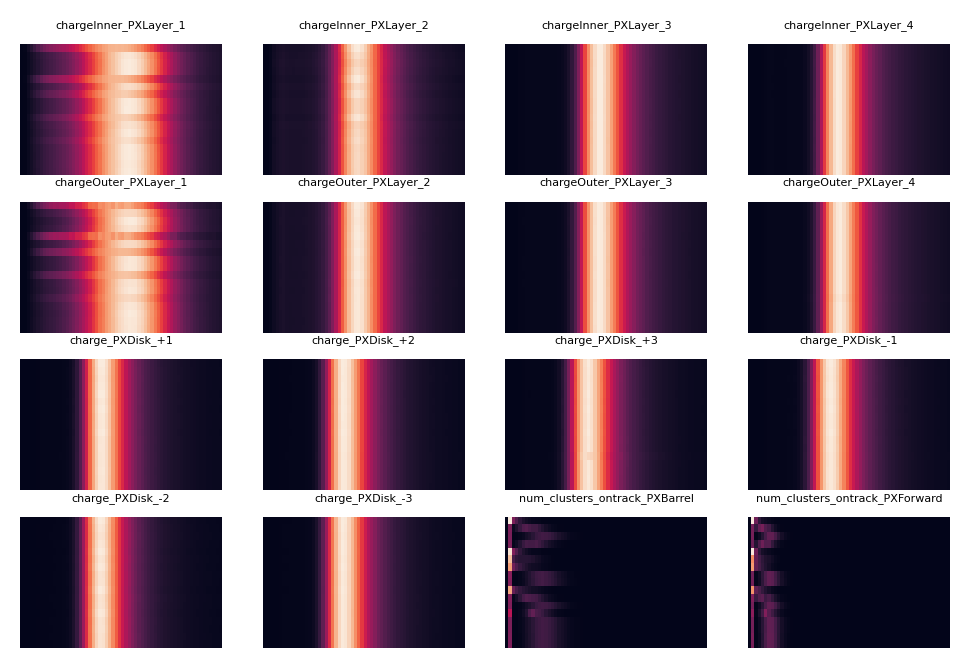

In [309]:
pltu.heatmaps(bad_recos[1], monitoring_elems, dpi=200)

Taking a look at the actual histograms...

In [312]:
fig, axes = plt.subplots(4, 4, figsize=(30,30), dpi=200)
axes = axes.flatten()

for i, ax in enumerate(axes):
    reco = bad_recos[3][i]
    test = badruns_norm[3][i]
    for j, histo in enumerate(reco):
        if j == 0: 
            ax.step(bins, histo, color='red', alpha=0.8, label='Reco')
            ax.step(bins, test[j], color='green', alpha=0.3, label='Input')
        ax.step(bins, histo, color='red', alpha=0.8)
        ax.step(bins, test[j], color='green', alpha=0.3)
    ax.step(bins, Xs_train_norm[i].mean(axis=0), color='blue', alpha=1, label='Train')
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(monitoring_elems[i], fontsize=12)   
plt.show()

With the reconstructions, we can now get the KL threshold.

In [315]:
# For each histogram of each ME type of each run, find the mean KL divergence
runKLs = []
for bad_reco, badrun in zip(bad_recos, badruns_norm):
    runKL = []
    for i in range(len(monitoring_elems)):
        runMEKL = kullback_leibler_divergence(bad_reco[i], badrun[i])
        runMEmeanKL = reduce_mean(runMEKL).numpy().item()
        runKL.append(np.array(runMEmeanKL))
    runKLs.append(np.array(runKL))
runKLs = np.array(runKLs)

This then gives us the final thresholds.

In [317]:
ME_thresholds = np.array(runKLs).mean(axis=0)
print(ME_thresholds)

[0.04684459 0.05879239 0.04766936 0.05523368 0.05765126 0.06389125
 0.05202571 0.05897123 0.05911965 0.06460776 0.07914176 0.05190368
 0.05145868 0.06521802 0.57887371 0.41326516]


<h1><font color='blue'>Good Run Evaluation & Analysis</font></h1>

We start by construction the evaluation dataset, i.e. a dataset containing the monitoring elements for runs which were certified as good and which have as reference run the same reference run that was used to train the autoencoder ensemble.

In [318]:
eval_df = megood_df[megood_df['refrun'] == 297178]
eval_runnum = eval_df['fromrun'].unique()

The available runs are the following

In [319]:
eval_runnum

array([297050, 297057, 297099, 297101, 297113, 297114, 297175, 297177,
       297215, 297218, 297225, 297296, 297411, 297426, 297431, 297434,
       297468, 297483, 297486, 297503, 297557, 297604, 297620, 297670,
       297674, 297722, 298997, 299000, 299061, 299065, 299067, 299096,
       299149, 299178, 299184, 299185, 299327, 299329])

In [322]:
evalruns = []
for evalrun in eval_runnum:
    evalruns.append(np.array([np.stack(eval_df[eval_df['fromrun']==evalrun][me+'_hist'].values) for me in monitoring_elems])[:,:,:62])
    
evalruns_norm = []
for evalrun in evalruns:
    temp = np.array(datau.normalizeMEs(evalrun, filterruns=False, emptyto0=True))
    evalruns_norm.append(temp)

As an example of what this data looks like, we can plot the heatmaps for the first available run which is 297050.

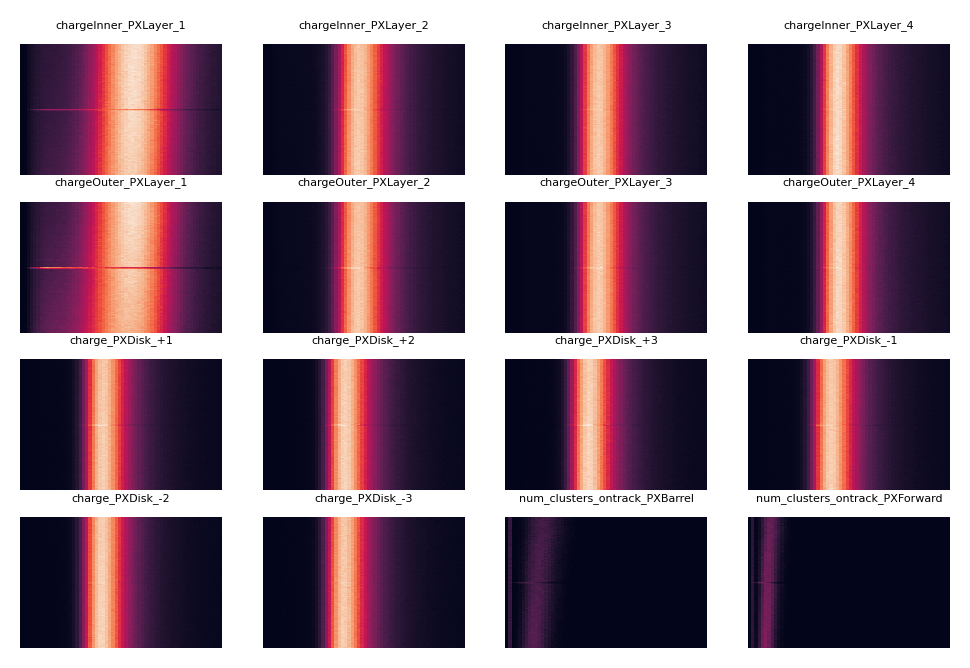

In [323]:
pltu.heatmaps(evalruns_norm[0], monitoring_elems, dpi=200)

We feed all of these runs into our autoencoder. As an example of the output, the heatmaps for run 297050 are shown.

In [324]:
eval_recos = []
for evalrun in evalruns_norm:
    eval_reco = []
    for i, (key, AE) in enumerate(ensemble.items()):
        eval_reco.append(AE(evalrun[i]))
    eval_recos.append(np.array(eval_reco))

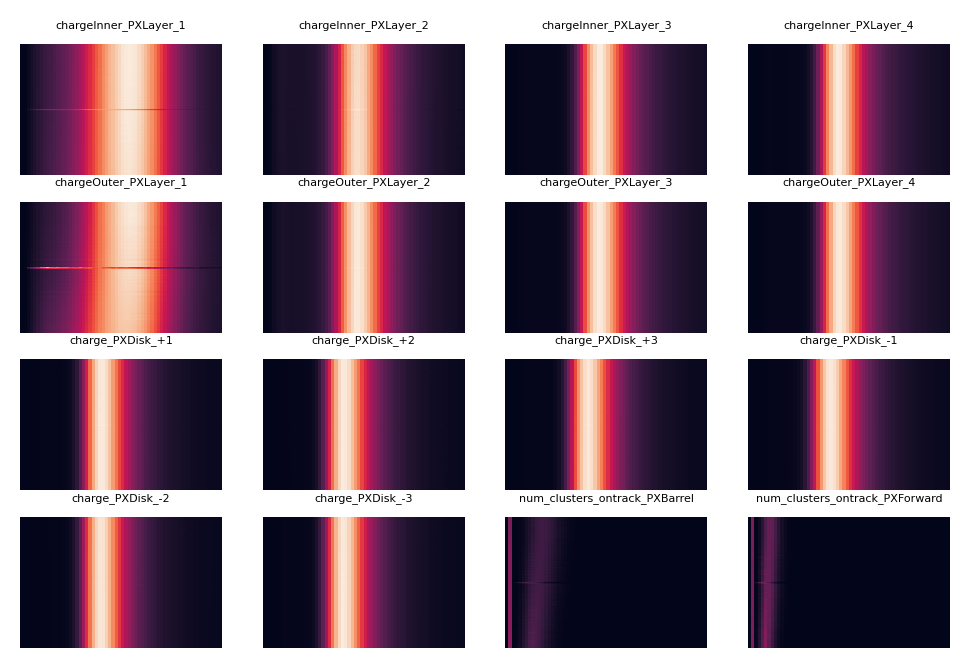

In [326]:
pltu.heatmaps(eval_recos[0], monitoring_elems, dpi=200)

With the reconstructions, we now find the KL divergence for all of them and proceed to compare the value for each of the monitoring elements for each of the runs to the corresponding threshold.

In [327]:
runKLs = []
for eval_reco, eval_run in zip(eval_recos, evalruns_norm):
    runKL = []
    for i in range(len(monitoring_elems)):
        runMEKL = kullback_leibler_divergence(eval_reco[i], eval_run[i])
        runMEmeanKL = reduce_mean(runMEKL).numpy().item()
        runKL.append(np.array(runMEmeanKL))
    runKLs.append(np.array(runKL))
runKLs = np.array(runKLs)

In [335]:
run_evals = []
for i, KLs in enumerate(runKLs):
    run_evals.append(KLs >= ME_thresholds)
run_evals = np.array(run_evals)

In [357]:
runevals_df = pd.DataFrame(run_evals, columns=monitoring_elems)
runevals_df.insert(0, 'fromrun', eval_runnum)
runevals_df.insert(1, 'num_bad_MEs', run_evals.sum(axis=1))
runevals_df

fromrun  num_bad_MEs  chargeInner_PXLayer_1  chargeInner_PXLayer_2  \
0    297050            0                  False                  False   
1    297057            0                  False                  False   
2    297099            0                  False                  False   
3    297101            0                  False                  False   
4    297113            0                  False                  False   
5    297114            0                  False                  False   
6    297175            0                  False                  False   
7    297177            0                  False                  False   
8    297215            0                  False                  False   
9    297218            0                  False                  False   
10   297225            0                  False                  False   
11   297296            0                  False                  False   
12   297411            0                  False                  False   
13   297426            0                  False                  False   
14   297431            0                  False                  False   
15   297434            0                  False                  False   
16   297468            0                  False                  False   
17   297483           14                   True                   True   
18   297486            0                  False                  False   
19   297503            0                  False                  False   
20   297557            0                  False                  False   
21   297604            0                  False                  False   
22   297620            0                  False                  False   
23   297670            0                  False                  False   
24   297674            0                  False                  False   
25   297722            0                  False                  False   
26   298997            1                  False                  False   
27   299000            2                   True                  False   
28   299061            2                   True                  False   
29   299065            2                   True                  False   
30   299067            2                   True                  False   
31   299096            1                  False                  False   
32   299149            1                  False                  False   
33   299178            1                  False                  False   
34   299184            2                   True                  False   
35   299185            2                   True                  False   
36   299327            2                   True                  False   
37   299329            2                   True                  False   

    chargeInner_PXLayer_3  chargeInner_PXLayer_4  chargeOuter_PXLayer_1  \
0                   False                  False                  False   
1                   False                  False                  False   
2                   False                  False                  False   
3                   False                  False                  False   
4                   False                  False                  False   
5                   False                  False                  False   
6                   False                  False                  False   
7                   False                  False                  False   
8                   False                  False                  False   
9                   False                  False                  False   
10                  False                  False                  False   
11                  False                  False                  False   
12                  False                  False                  False   
13                  False                  False                  F

We can clearly see that almost all but one of the run have between 0 to 2 'bad' monitoring elements and that, for these runs, the only monitoring elements which are bad are `chargeOuter_PXLayer_1` and `chargeInner_PXLayer_1`, serving as an indication that, at the time, those particular sub-systems had some sort of issues. Considering these aformentioned runs had almost if not all their monitoring elements not having any problems, they could be considered as truly good runs (i.e. true positives).

On the other hand, there is a particular run which has *14* bad monitoring elements. We take a closer look at this to see what is happening.

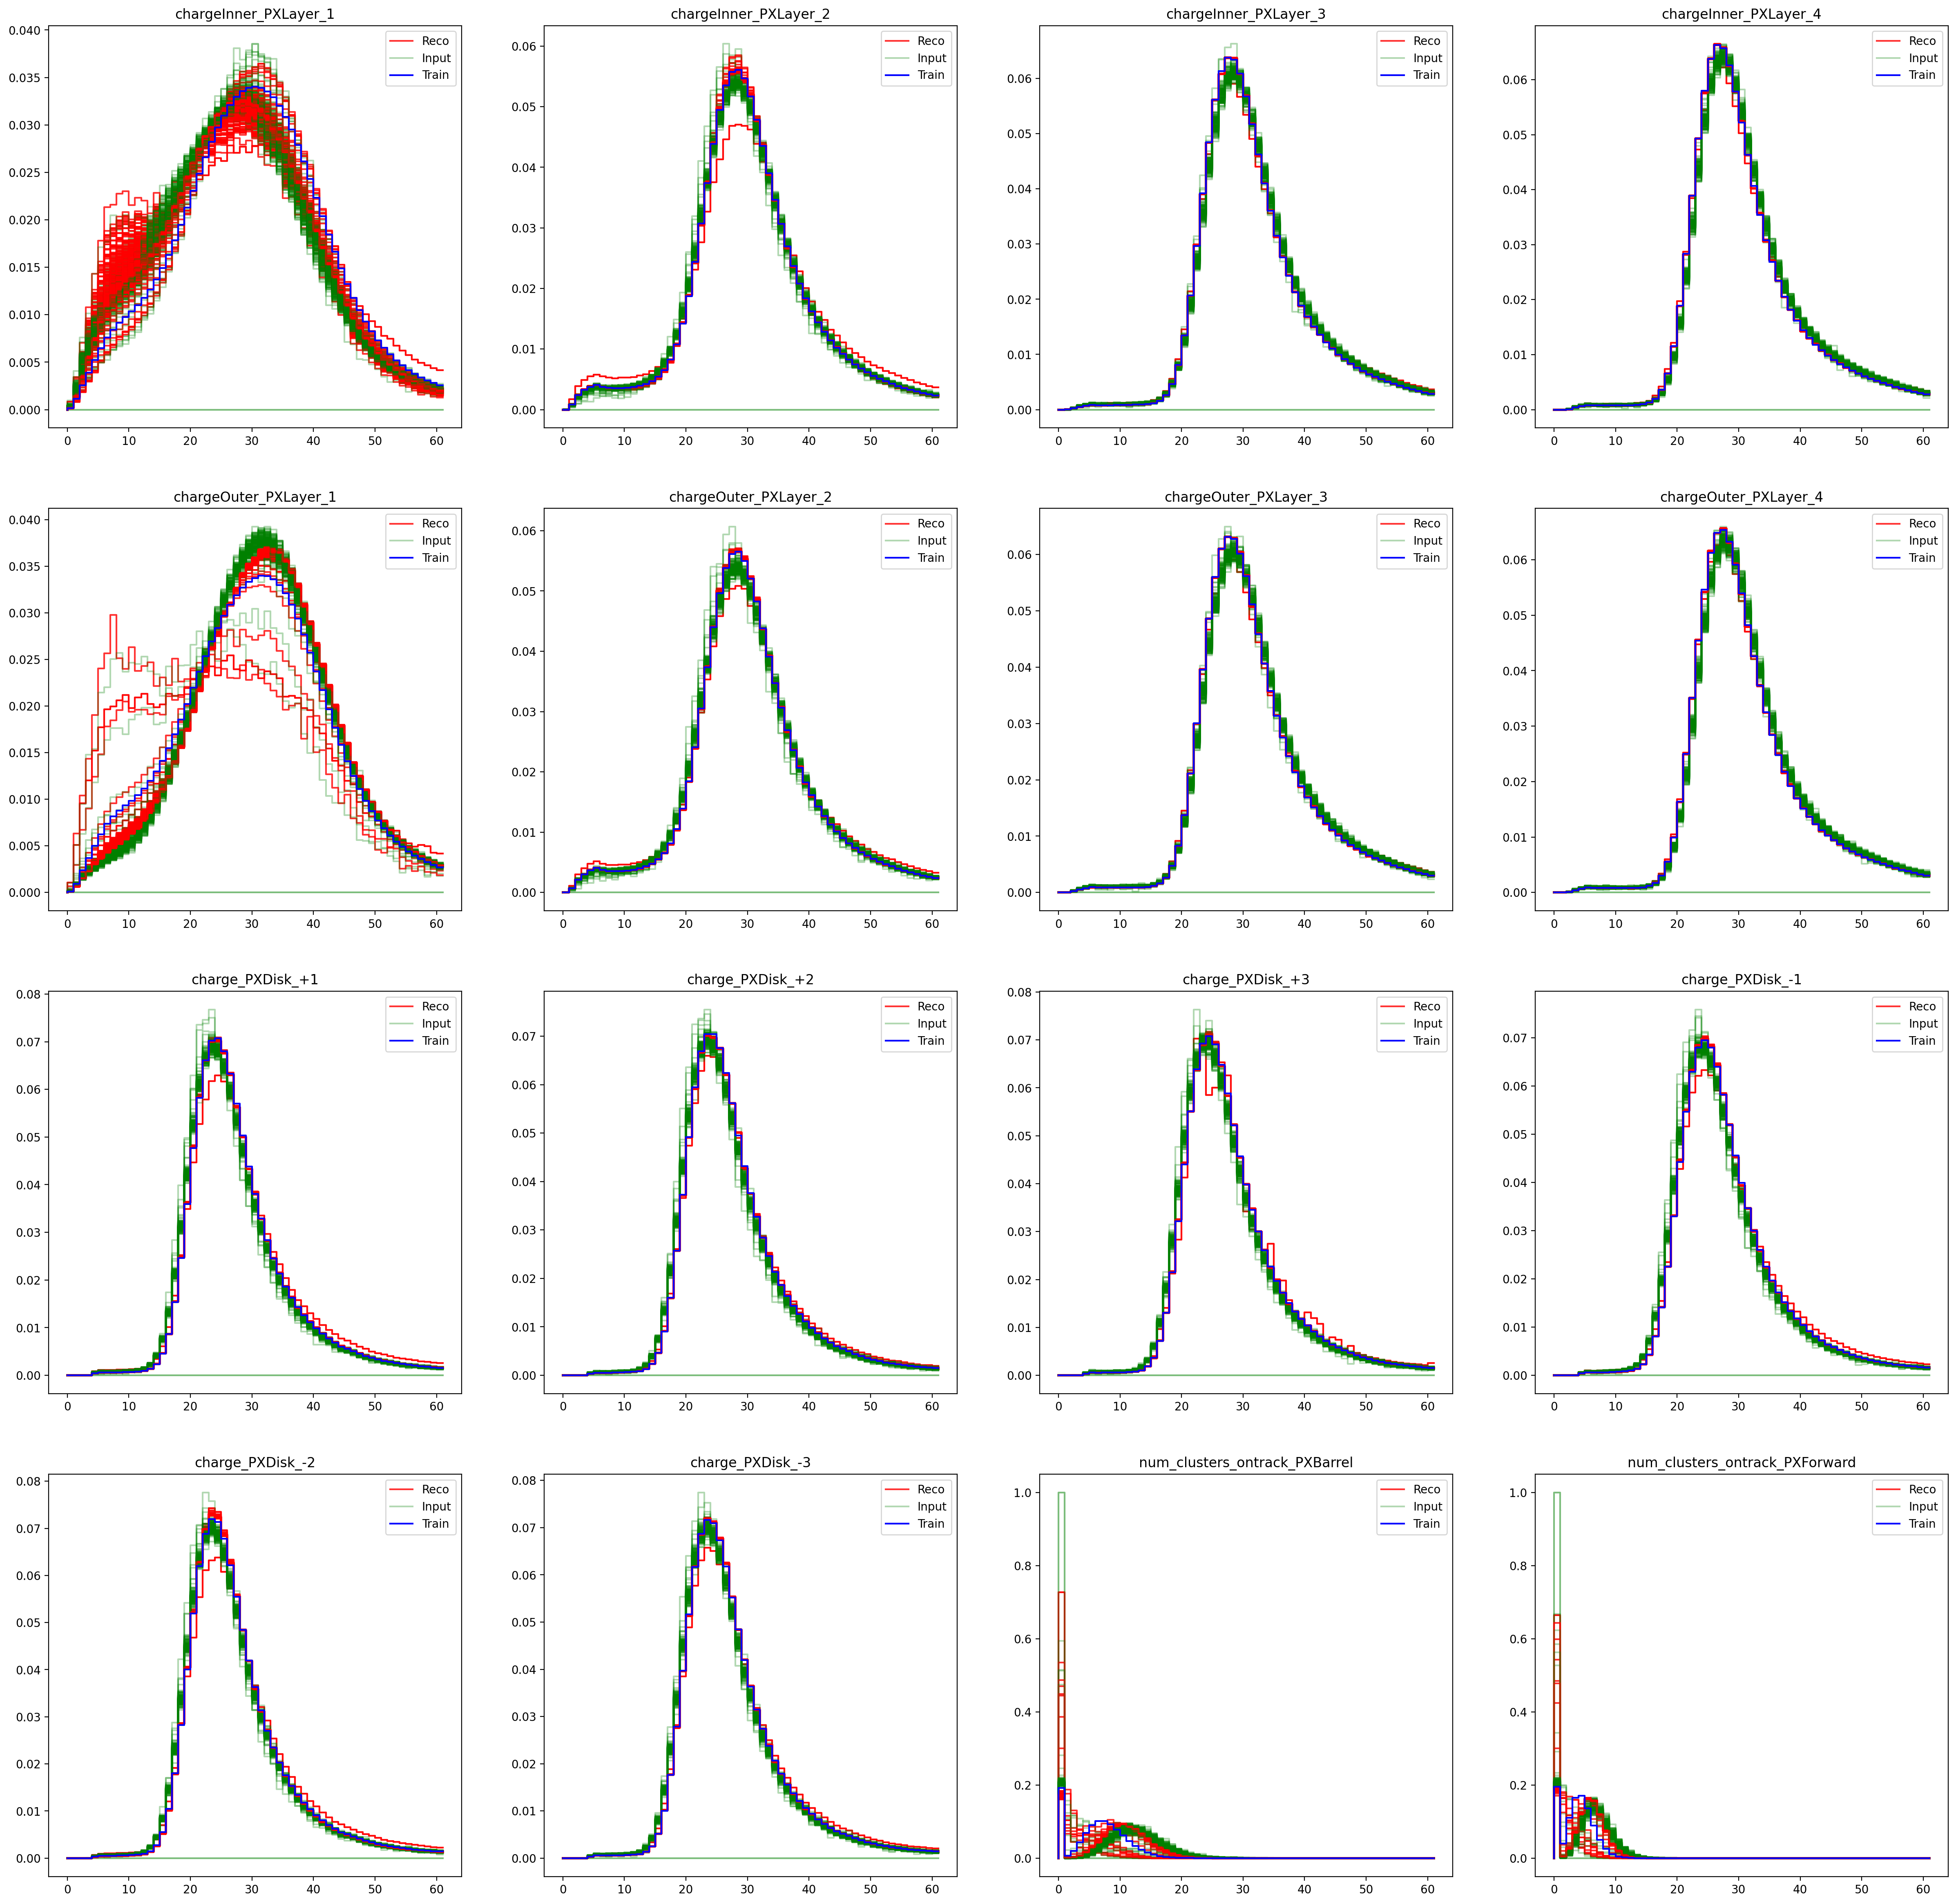

In [361]:
fig, axes = plt.subplots(4, 4, figsize=(30,30), dpi=200)
axes = axes.flatten()

for i, ax in enumerate(axes):
    reco = eval_recos[17][i]
    test = evalruns_norm[17][i]
    for j, histo in enumerate(reco):
        if j == 0: 
            ax.step(bins, histo, color='red', alpha=0.8, label='Reco')
            ax.step(bins, test[j], color='green', alpha=0.3, label='Input')
        ax.step(bins, histo, color='red', alpha=0.8)
        ax.step(bins, test[j], color='green', alpha=0.3)
    ax.step(bins, Xs_train_norm[i].mean(axis=0), color='blue', alpha=1, label='Train')
    ax.legend(loc='upper right')
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_title(monitoring_elems[i], fontsize=12)   
plt.show()

At a first glance, it seems like the autoencoder actually did a great job at reconstructing all but the `chargeInner_PXLayer_1` and `chargeOuter_PXLayer_1` histograms. If we pay close attention though, we can see that all of the monitoring elements have a certain amount of LSs for which it seems like the Pixel Phase 1 was not taking any data. This indicates that the Pixel might have been off for a certain period of time during the run. We check this in two ways. The first way is by checking those LSs for which we have empty histograms.

In [389]:
evalruns_norm[17][0].sum(axis=1)

array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Note that, curiously, only the very first lumisection has 0 entries. The fact that the presence of this single empty histogram caused the majority of monitoring elements to be above their respective KL thresholds indicates that our approach is very sensitive to these types of empty histograms.

Another thing we can check is the lumisection number at which this empty histogram appears. This can be done by checking `megood_df`. If we check this dataframe, we can see that the lumisection number for this lumisection is 37.

In [388]:
megood_df[megood_df['fromrun'] == 297483]

fromrun  fromlumi  entries  \
14002   297483        37        0   
14003   297483        40    50886   
14004   297483        41   161694   
14005   297483        42   168686   
14006   297483        43   173030   
...        ...       ...      ...   
14171   297483       208   160137   
14172   297483       209   152292   
14173   297483       210   157939   
14174   297483       211   157653   
14175   297483       212   131723   

                              chargeInner_PXLayer_1_hist  \
14002  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
14003  [0, 33, 153, 311, 379, 477, 641, 734, 775, 797...   
14004  [0, 96, 478, 917, 1377, 1761, 2003, 2240, 2428...   
14005  [0, 84, 518, 998, 1465, 1814, 2188, 2396, 2622...   
14006  [0, 88, 499, 999, 1357, 1840, 2148, 2470, 2650...   
...                                                  ...   
14171  [0, 71, 385, 721, 977, 1319, 1446, 1646, 1758,...   
14172  [0, 60, 329, 612, 943, 1232, 1435, 1600, 1772,...   
14173  [0, 55, 349, 691, 935, 1224, 1375, 1635, 1791,...   
14174  [0, 71, 342, 664, 994, 1240, 1448, 1632, 1709,...   
14175  [0, 50, 309, 565, 768, 1020, 1150, 1375, 1544,...   

                              chargeInner_PXLayer_2_hist  \
14002  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
14003  [0, 0, 18, 98, 116, 127, 161, 123, 150, 142, 1...   
14004  [0, 1, 94, 253, 355, 459, 481, 455, 451, 456, ...   
14005  [0, 0, 96, 283, 396, 433, 521, 459, 493, 496, ...   
14006  [0, 0, 88, 279, 365, 500, 508, 494, 505, 428, ...   
...                                                  ...   
14171  [0, 0, 98, 237, 375, 449, 445, 439, 458, 449, ...   
14172  [0, 0, 108, 217, 353, 362, 441, 418, 455, 430,...   
14173  [0, 0, 110, 250, 360, 390, 488, 466, 443, 429,...   
14174  [0, 2, 107, 274, 314, 422, 477, 412, 444, 462,...   
14175  [0, 2, 81, 246, 295, 385, 384, 343, 346, 361, ...   

                              chargeInner_PXLayer_3_hist  \
14002  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
14003  [0, 0, 0, 8, 25, 21, 31, 26, 26, 24, 37, 29, 3...   
14004  [0, 0, 2, 24, 60, 75, 105, 105, 91, 106, 108, ...   
14005  [0, 0, 1, 29, 70, 87, 104, 96, 96, 95, 109, 10...   
14006  [0, 0, 2, 38, 64, 86, 94, 121, 116, 88, 118, 1...   
...                                                  ...   
14171  [0, 0, 2, 40, 61, 87, 93, 84, 101, 107, 97, 10...   
14172  [0, 0, 1, 30, 62, 76, 88, 108, 91, 89, 99, 74,...   
14173  [0, 0, 3, 31, 64, 71, 90, 87, 96, 84, 99, 102,...   
14174  [0, 0, 0, 29, 58, 80, 83, 102, 87, 75, 97, 105...   
14175  [0, 0, 1, 23, 64, 68, 76, 77, 77, 73, 78, 60, ...   

                              chargeInner_PXLayer_4_hist  \
14002  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
14003  [0, 0, 0, 4, 10, 20, 11, 23, 22, 18, 23, 21, 2...   
14004  [0, 0, 0, 7, 39, 61, 79, 79, 69, 60, 60, 85, 6...   
14005  [0, 0, 0, 4, 46, 65, 82, 77, 66, 78, 75, 75, 8...   
14006  [0, 0, 0, 9, 44, 64, 65, 77, 66, 88, 71, 70, 7...   
...                                                  ...   
14171  [0, 0, 0, 4, 29, 52, 57, 75, 72, 73, 61, 68, 6...   
14172  [0, 0, 0, 8, 45, 66, 69, 74, 44, 57, 74, 70, 7...   
14173  [0, 0, 0, 3, 40, 47, 79, 85, 70, 68, 61, 72, 7...   
14174  [0, 0, 0, 7, 56, 49, 70, 60, 72, 73, 73, 50, 6...   
14175  [0, 0, 0, 10, 24, 41, 71, 51, 39, 47, 58, 51, ...   

                              chargeOuter_PXLayer_1_hist  \
14002  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
14003  [0, 8, 41, 85, 128, 161, 157, 234, 232, 219, 2...   
14004  [0, 28, 145, 301, 450, 555, 643, 687, 803, 837...   
14005  [0, 29, 164, 339, 489, 575, 662, 784, 834, 925...   
14006  [0, 25, 168, 339, 492, 613, 715, 793, 884, 974...   
...                                                  ...   
14171  [0, 21, 121, 240, 353, 363, 474, 544, 535, 634...   
14172  [0, 21, 129, 245, 308, 399, 453, 506, 561, 614...   
14173  [0, 19, 113, 230, 310, 422, 452, 455, 582, 600...   
14174  [0, 28, 121, 240, 314, 379, 457, 483, 531, 613...   
14175  [0, 11, 103

In order to see if the problem is truly due to the Pixel being off, we can check a website that shifted look at during shifts to get a lot of information on the run they are trying to certify. This website is named OMS and in it we can check if the high voltage was on at each of the lumisection for each of the components of the detector. Below is a screenshot of the high voltage status information for run 297483. We can see that before LS before lumisection 37 OMS indicates that the high voltage was off, but that in lumisecion 37 it was on. Keeping in mind that a lumisection is ~23 seconds of data taking, he fact that the monitoring elements appear as empty histograms would indicate that, although this lumisection has high voltage on, this might have just been at the very end of the lumisection, and during that exceedingly short period of time, no data was taken. Another, more likely explanation is that this is an erroneous bit assignment by the Detector Control System (DCS), the system which is responsible for controlling and monitoring the various subsystems of the CMS detector. 

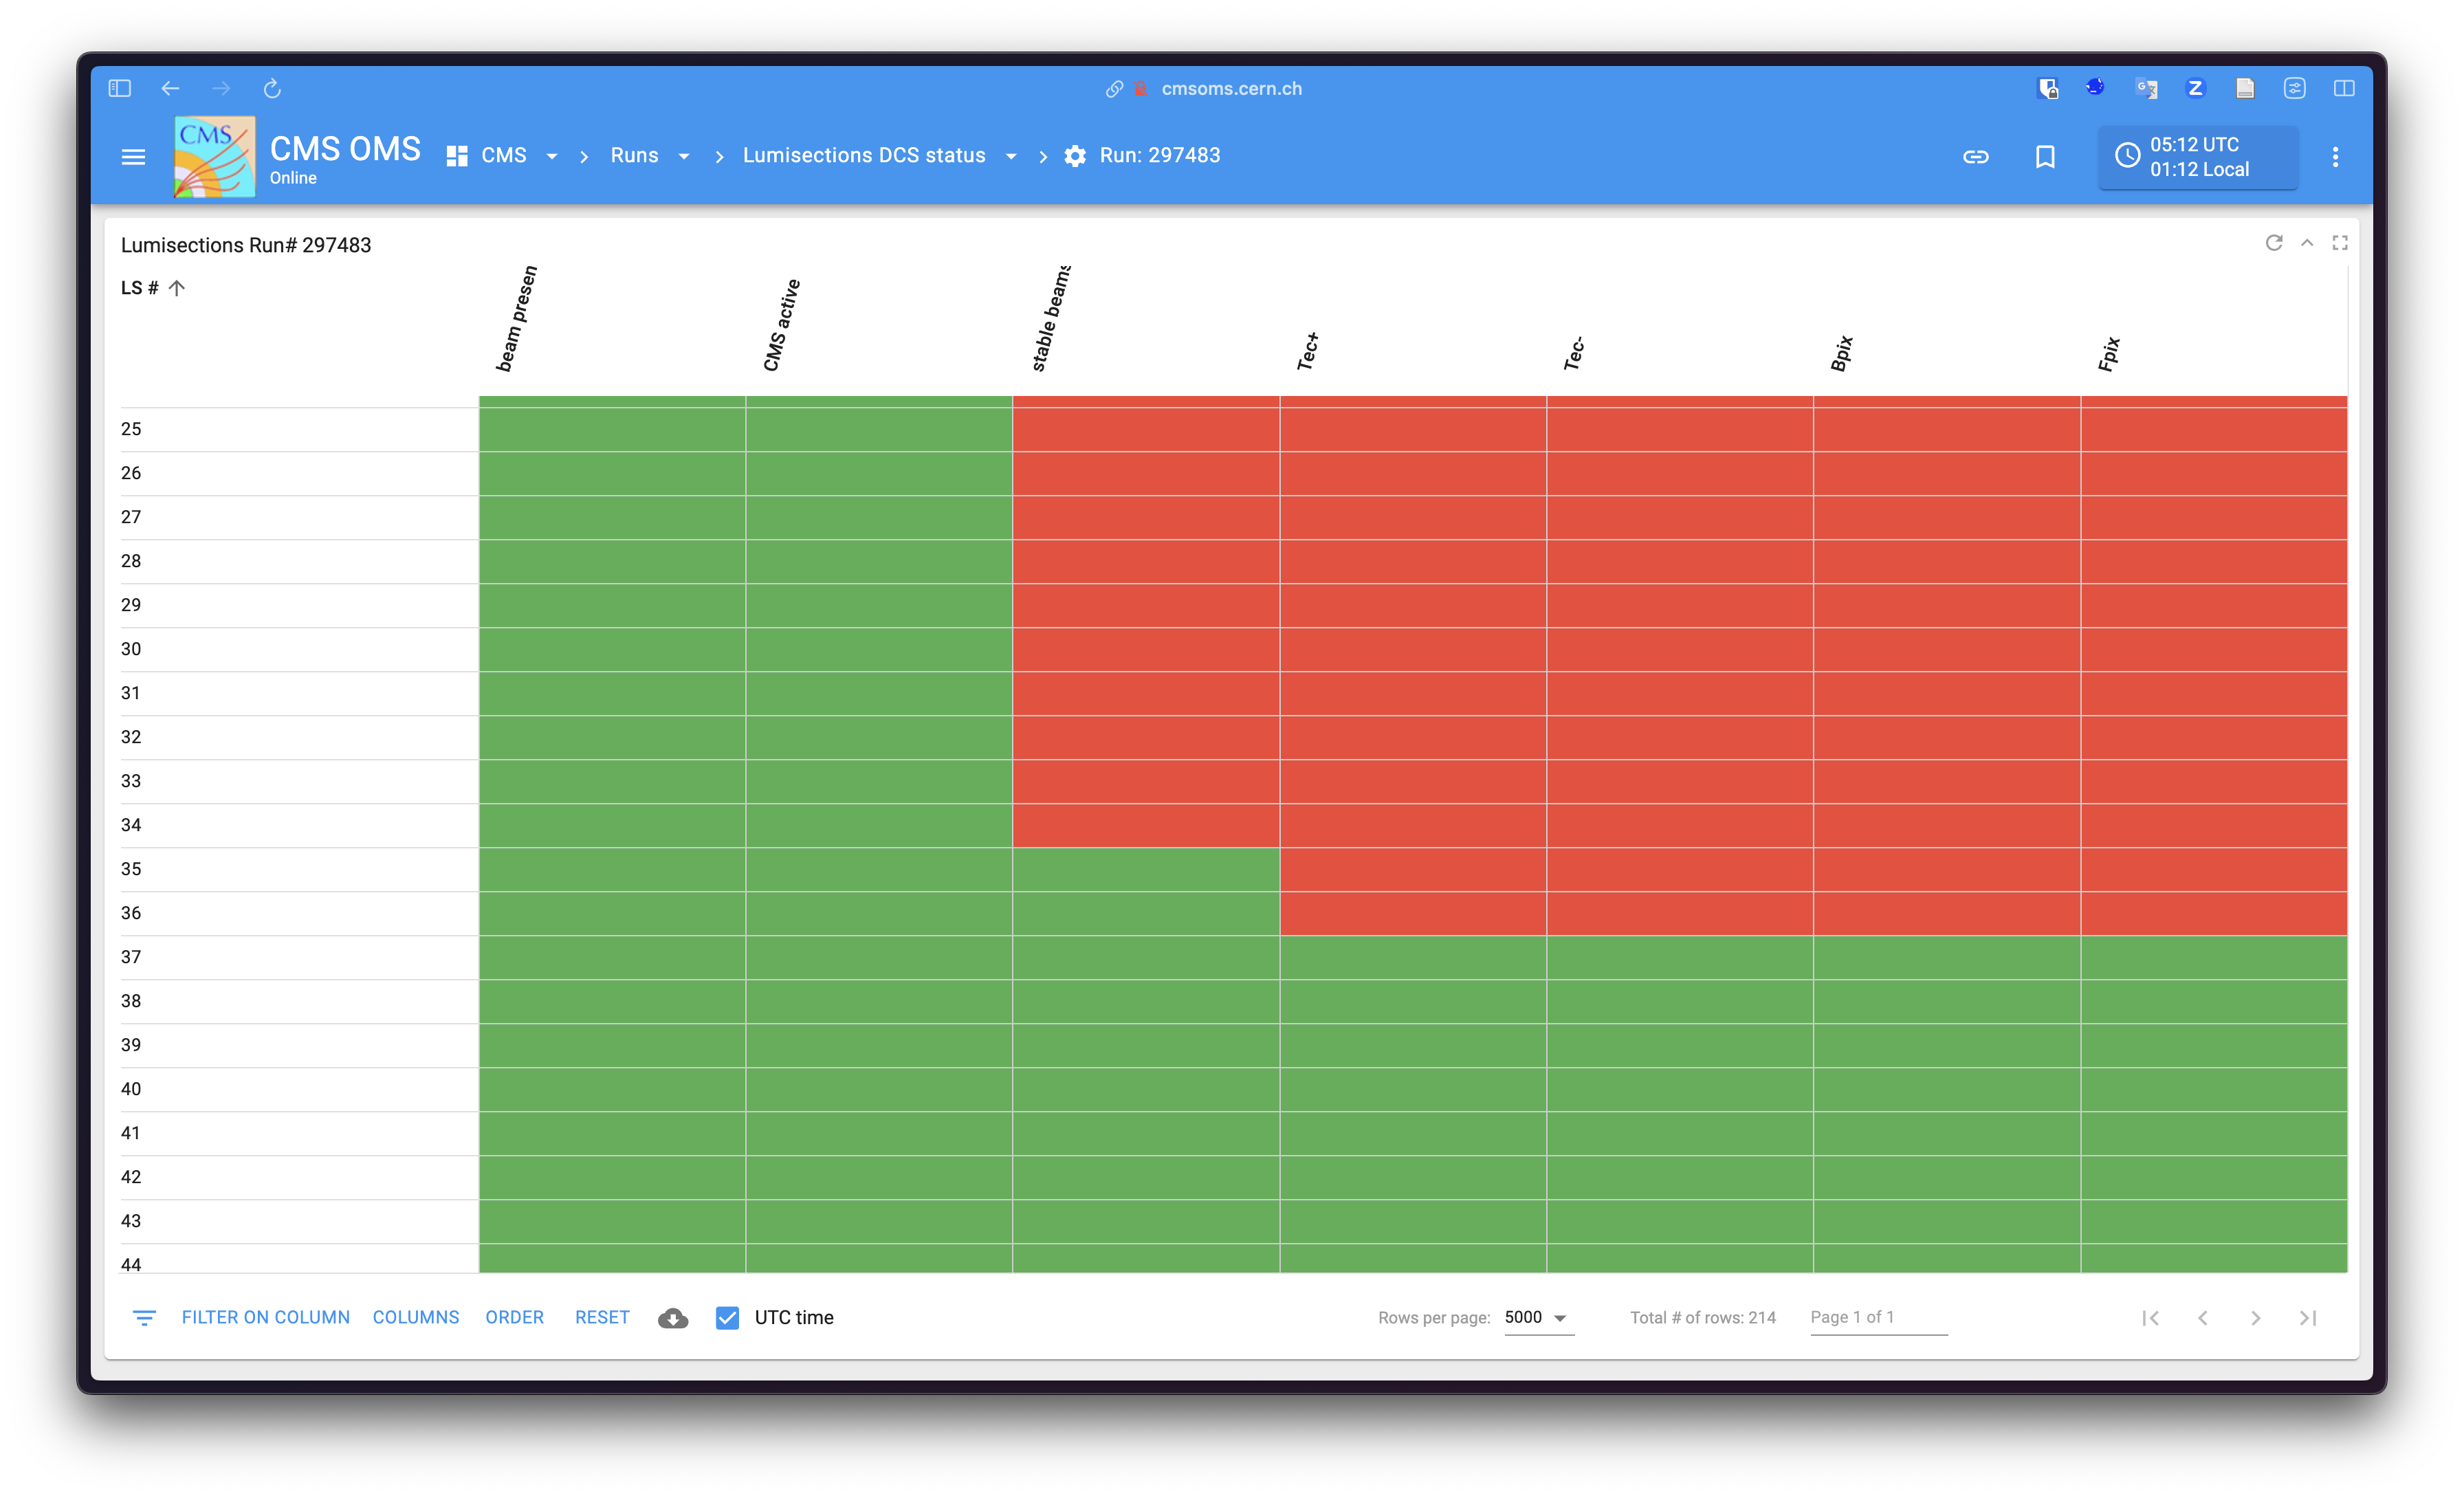

Whatever the problem may be, we can re-evaluate run 297483, but without that first lumisection to see if it makes a difference and to confirm this approache's sensitivity to empty histograms.

In [430]:
run483MEs = evalruns_norm[17]
run483MEs = run483MEs[:, 1:]

In [452]:
run483_eval = []
for i, (key, AE) in enumerate(ensemble.items()):
    KLs = kullback_leibler_divergence(AE(run483MEs[i]), run483MEs[i])
    run483_eval.append(reduce_mean(KLs).numpy().item())
run483_eval = run483_eval >= ME_thresholds

Taking a look at the results, we can see that after removing the empty lumisecion, all of the monitoring element types give an average KL divergence which is less than their respective thresholds and we can thus conclude there is nothing actually wrong with this run.

In [449]:
pd.DataFrame([run483_eval], columns=monitoring_elems)

chargeInner_PXLayer_1  chargeInner_PXLayer_2  chargeInner_PXLayer_3  \
0                  False                  False                  False   

   chargeInner_PXLayer_4  chargeOuter_PXLayer_1  chargeOuter_PXLayer_2  \
0                  False                  False                  False   

   chargeOuter_PXLayer_3  chargeOuter_PXLayer_4  charge_PXDisk_+1  \
0                  False                  False             False   

   charge_PXDisk_+2  charge_PXDisk_+3  charge_PXDisk_-1  charge_PXDisk_-2  \
0             False             False             False             False   

   charge_PXDisk_-3  num_clusters_ontrack_PXBarrel  \
0             False                          False   

   num_clusters_ontrack_PXForward  
0                           False

<h1><font color='blue'>Conclusion</font></h1>

In this notebook, we have constructed an convolutional autoencoder ensemble capable of reconstructing Pixel lumisection level monitoring elements. By training it with a single reference run, we were able to see that all of the runs that were certified as good were indeed good and that the only outlier was due to this approach's sensitivity to empty lumisections. In future work, we could fine tune our approach so as to avoid this over-sensitivity, further test the ensemble and even expand it so as to see how it performs with other monitoring elements.